# Handle Outliers

Outliers in datasets can be determined or removed using either gaussian method or IQR method based on data distribution (gaussian vs non-gaussian)

<b>Gaussian method</b>: Outliers are points that lie beyond 3 standard deviations away from the mean

<b>IQR method</b>: Outliers are points that lie beyond 1.5 interquartile range away from 25th and 75th percentile.

After determining outliers and data distribution type, outliers can be handled using one of the following methods:
1. Capping outliers at boundary ends
2. Removing outliers

Note that outlier treatment methods require proper caution, as simply removing outliers from the dataset may not always improve the performance of Machine Learning models.

If proportion of outliers is large (i.e. more than 10%), these outliers require further investigation.

Outliers should only be removed in the following scenarios if confirmed:

1. Data points are not related to the target population.
2. Data points are incorrectly recorded and could not be fixed.

If uncertain about outlier treatment method, consider all possible approaches and compare the difference in results from model training for better decision making.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import feature_engine.outliers as feo
import feature_engine.imputation as fei
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

In [2]:
data = pd.read_csv('owid-covid-data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155858 entries, 0 to 155857
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    155858 non-null  object 
 1   continent                                   146487 non-null  object 
 2   location                                    155858 non-null  object 
 3   date                                        155858 non-null  object 
 4   total_cases                                 153028 non-null  float64
 5   new_cases                                   152977 non-null  float64
 6   new_cases_smoothed                          151826 non-null  float64
 7   total_deaths                                135644 non-null  float64
 8   new_deaths                                  135820 non-null  float64
 9   new_deaths_smoothed                         135688 non-null  float64
 

In [3]:
numerical_columns = []
categorical_columns = []
for column in data.columns:
    if data[column].dtype == float:
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

In [4]:
# Handling missing numerical values
imputer = IterativeImputer(max_iter = 1000, verbose=1)
data[numerical_columns] = pd.DataFrame(imputer.fit_transform(data[numerical_columns]), columns = numerical_columns)

[IterativeImputer] Completing matrix with shape (155858, 62)
[IterativeImputer] Change: 5898399723.477336, scaled tolerance: 9788986.851 
[IterativeImputer] Change: 7639856.679538702, scaled tolerance: 9788986.851 
[IterativeImputer] Early stopping criterion reached.


In [5]:
data[categorical_columns].isnull().sum()/len(data)

iso_code       0.000000
continent      0.060125
location       0.000000
date           0.000000
tests_units    0.495117
dtype: float64

In [6]:
# Frequent category imputation
catimputer = fei.CategoricalImputer(imputation_method='frequent', variables='continent')
data = catimputer.fit_transform(data)

In [7]:
# Missing category imputation
catimputer = fei.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables='tests_units')
data = catimputer.fit_transform(data)

In [8]:
# Checking for gaussian distribution of numerical variables using anderson test
gaussian_columns = []
non_gaussian_columns = []
for column in numerical_columns:
    result = st.anderson(data[column])
    if result[0] > result[1][2]:
        non_gaussian_columns.append(column)
    else:
        gaussian_columns.append(column)
print(f"List of gaussian variables: {gaussian_columns}")
print(f"List of non-gaussian variables: {non_gaussian_columns}")

List of gaussian variables: []
List of non-gaussian variables: ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'tot

In [9]:
# Checking proportion of outliers
outlier_prop = []
for column in non_gaussian_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_prop.append(np.round(len(data[(data[column] < lower_bound) | (data[column] > upper_bound)])/len(data),4))
results = pd.concat([pd.Series(data[non_gaussian_columns].columns),pd.Series(outlier_prop)],axis=1)\
            .rename({0:'Variable',1:'Prop_Outliers'},axis=1)
results.sort_values(by='Prop_Outliers',ascending=False).head(10)

,Variable,Prop_Outliers
28,tests_per_case,0.2930
35,total_vaccinations_per_hundred,0.2518
37,people_fully_vaccinated_per_hundred,0.2432
36,people_vaccinated_per_hundred,0.2415
15,hosp_patients,0.1992
1,new_cases,0.1694
2,new_cases_smoothed,0.1685
0,total_cases,0.1645
43,population,0.1392
49,extreme_poverty,0.1391


## Capping outliers at extreme value bound (Winsorizer)

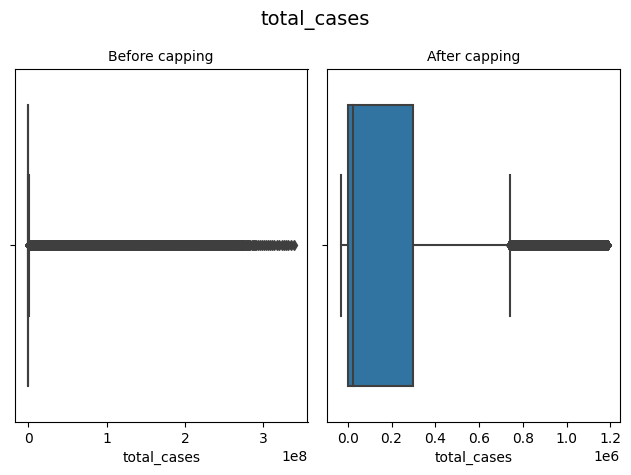

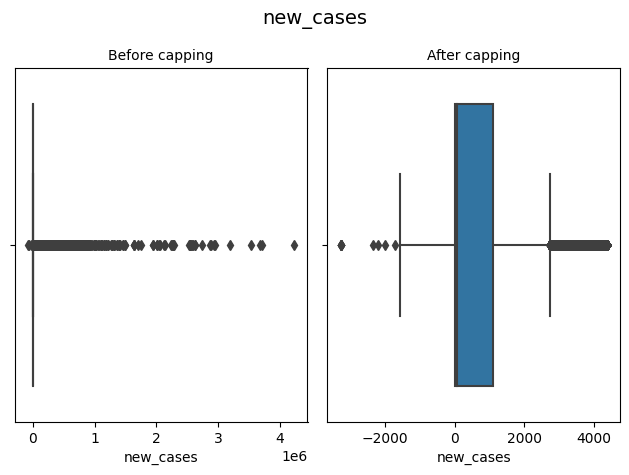

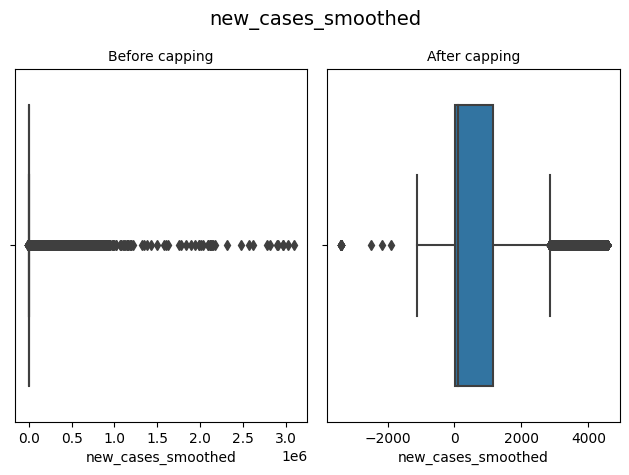

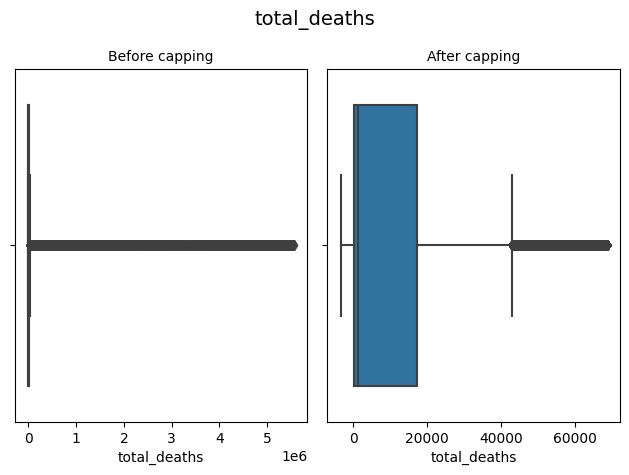

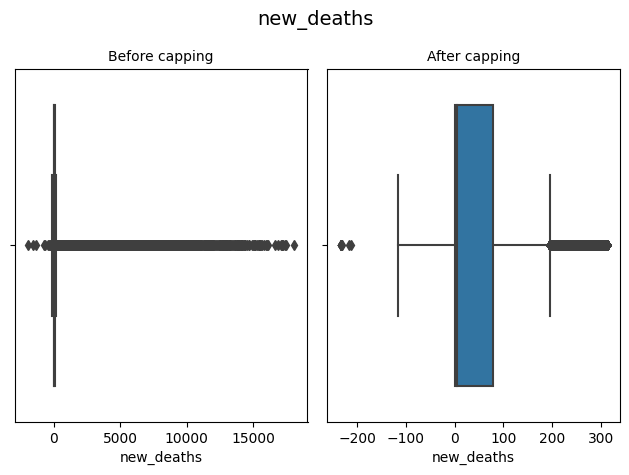

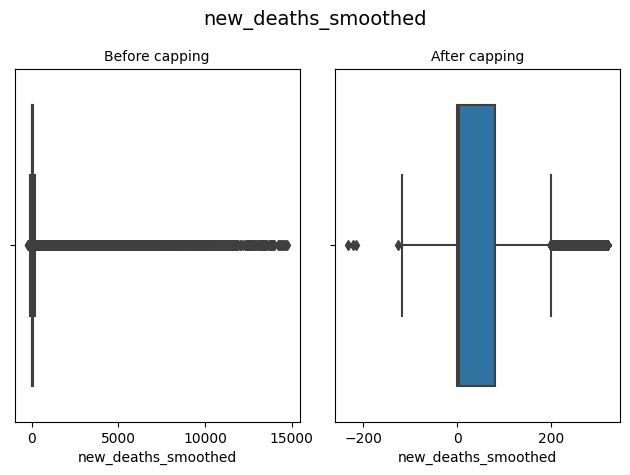

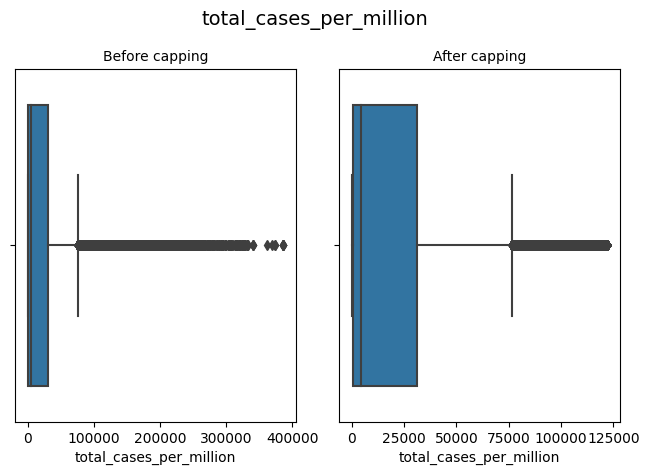

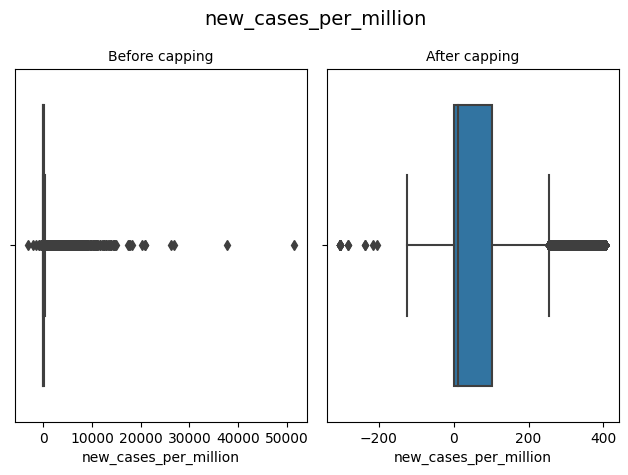

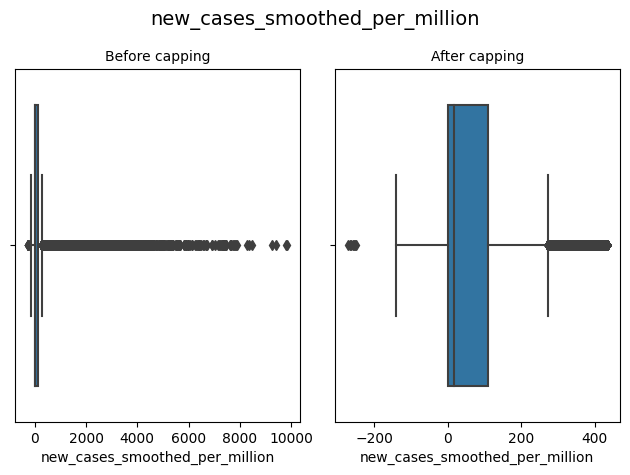

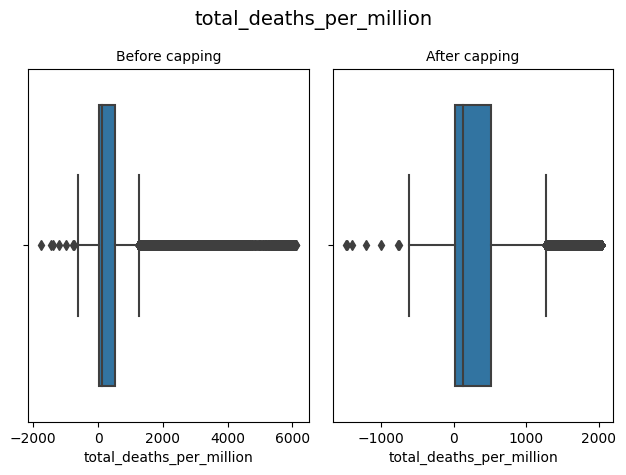

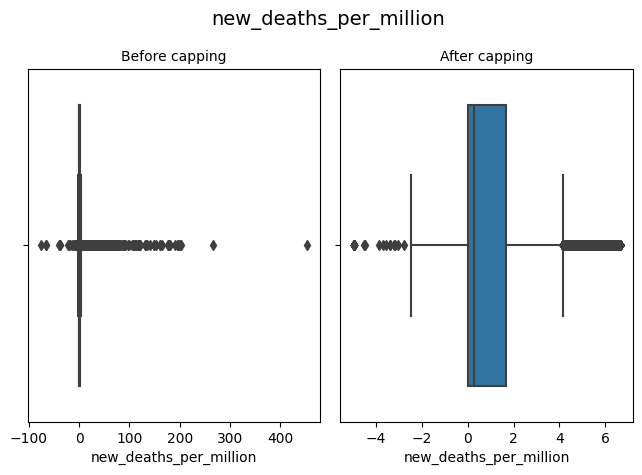

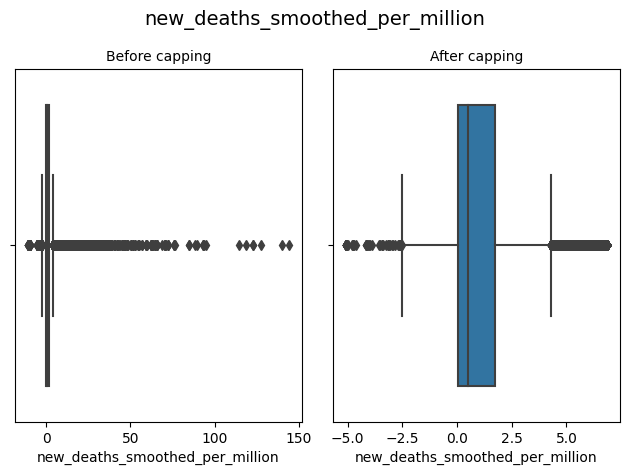

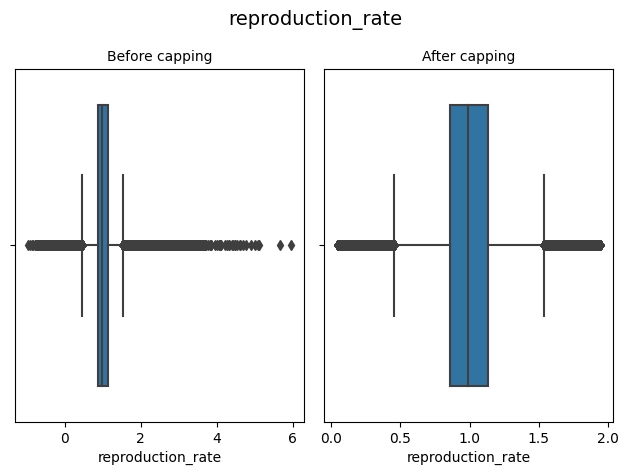

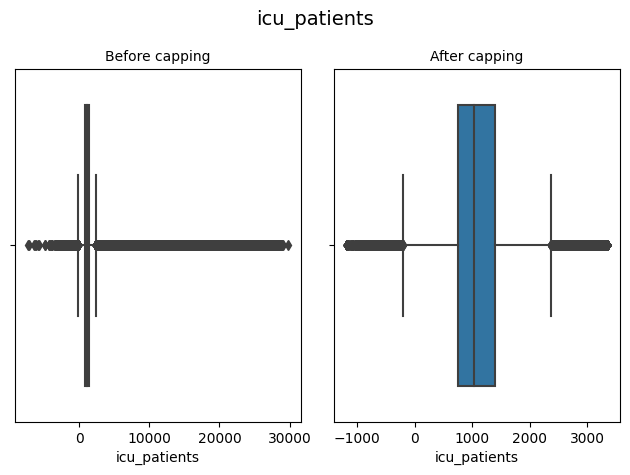

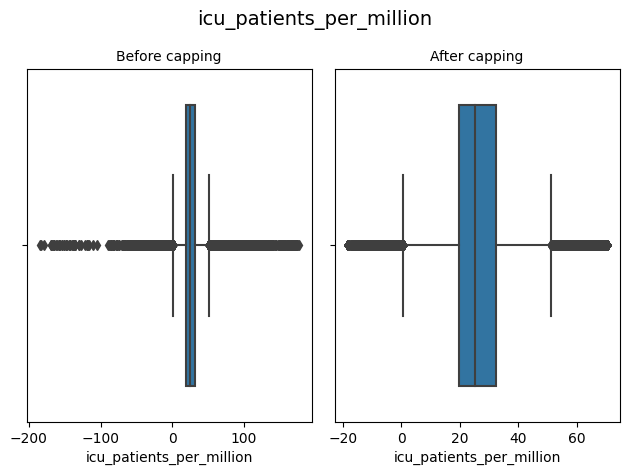

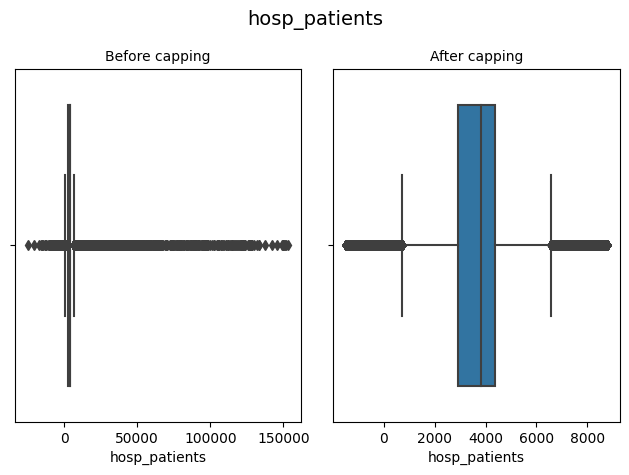

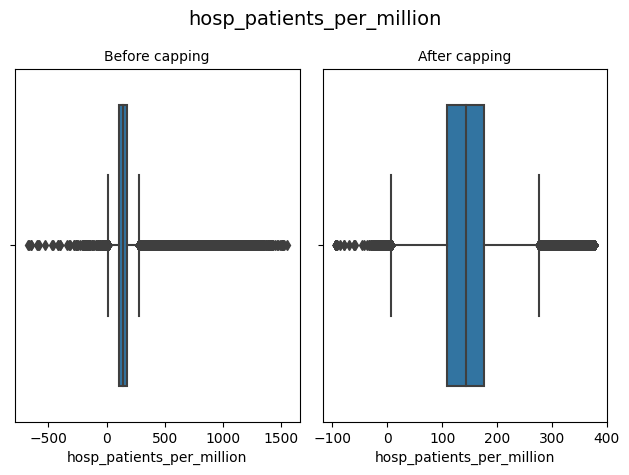

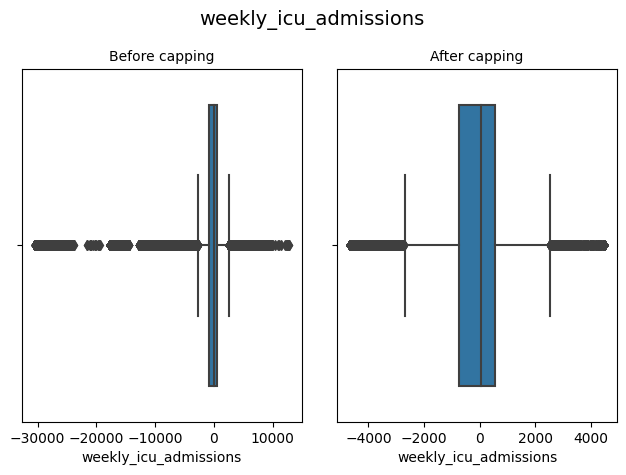

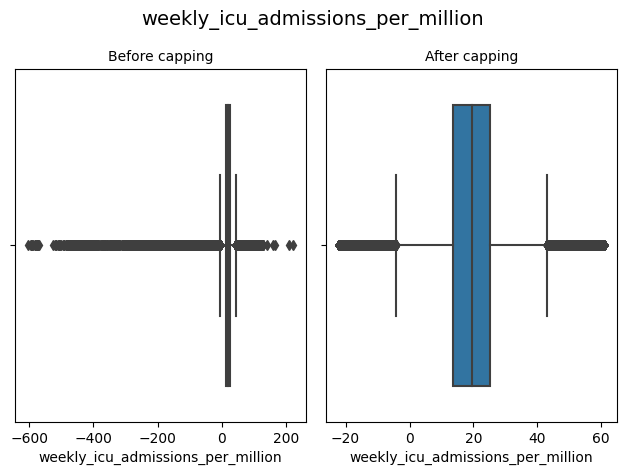

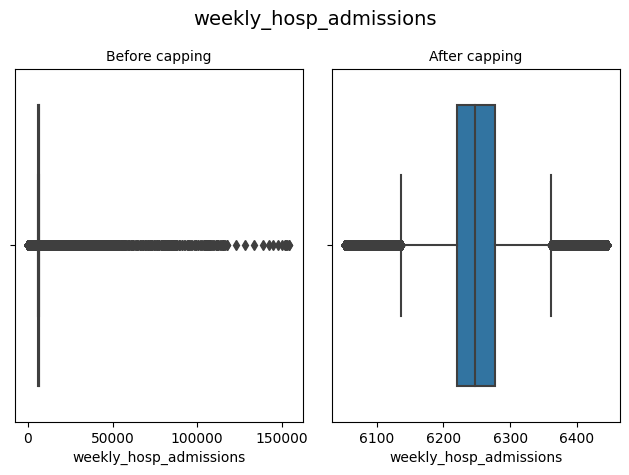

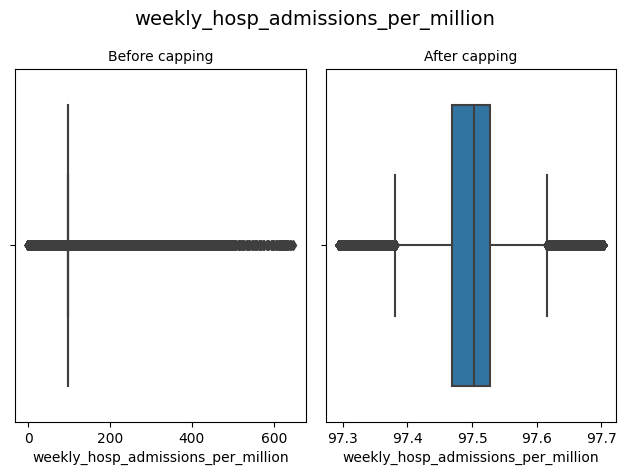

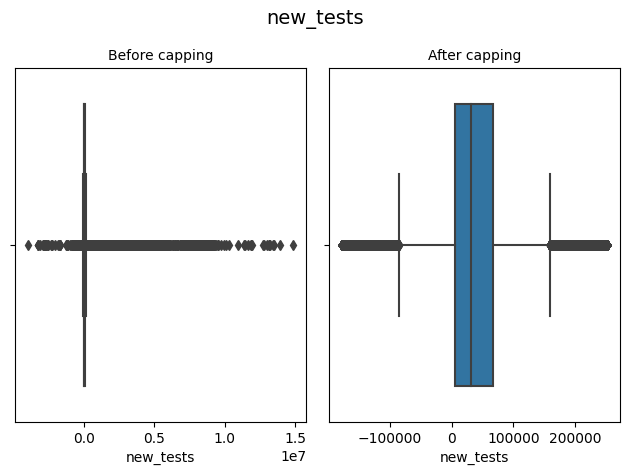

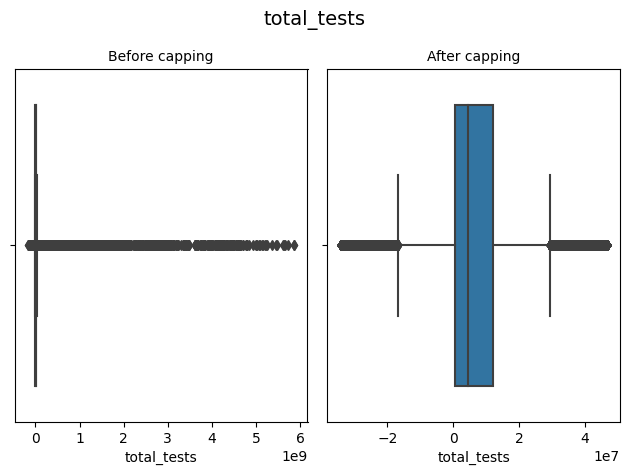

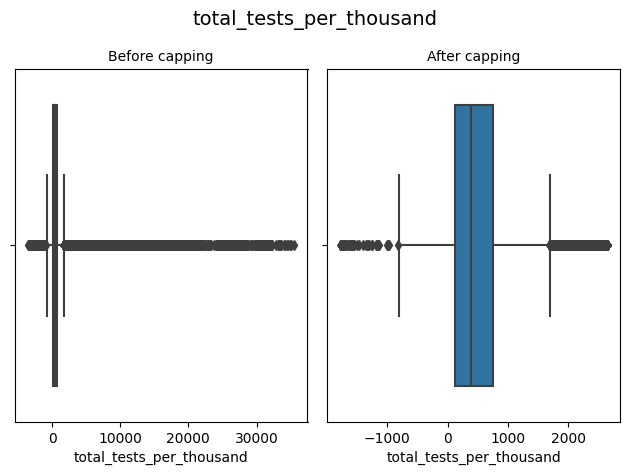

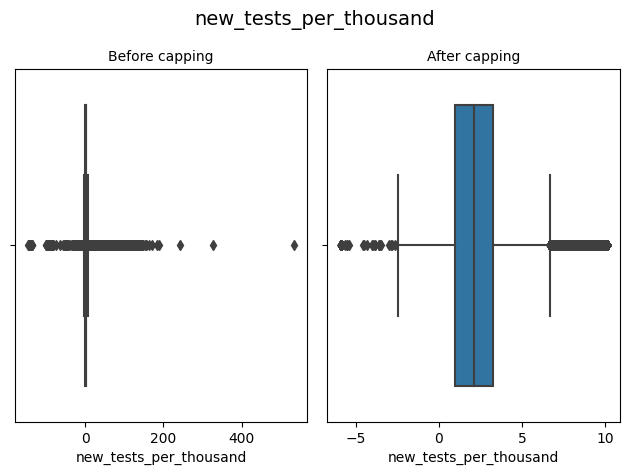

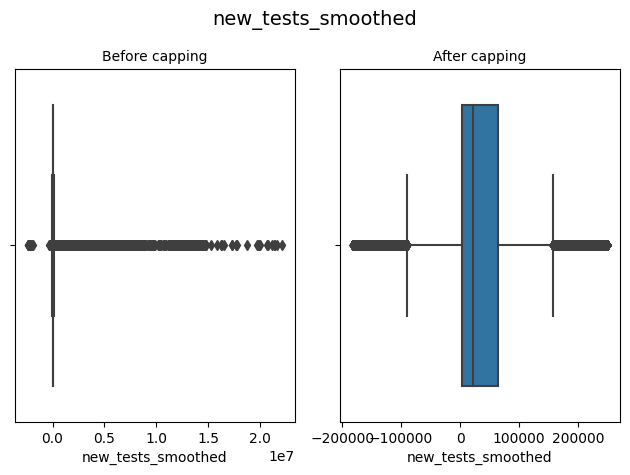

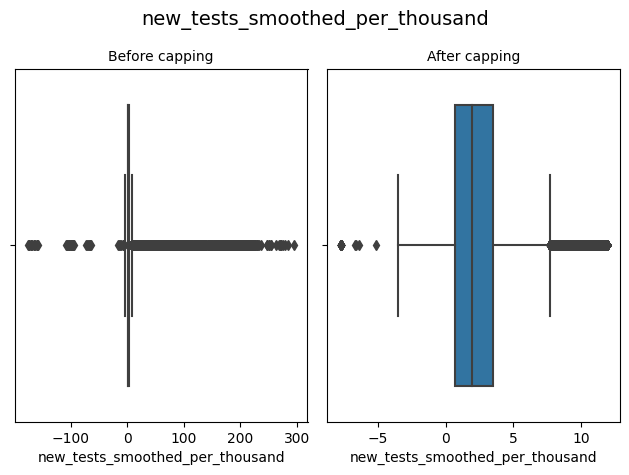

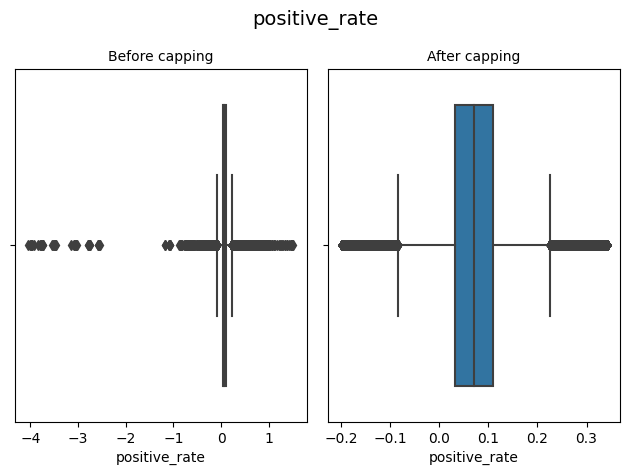

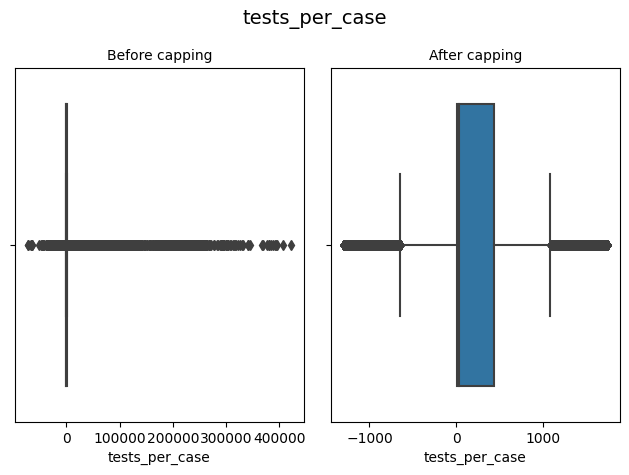

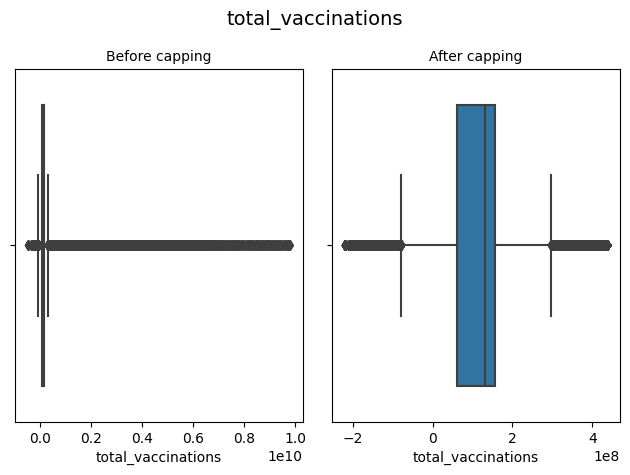

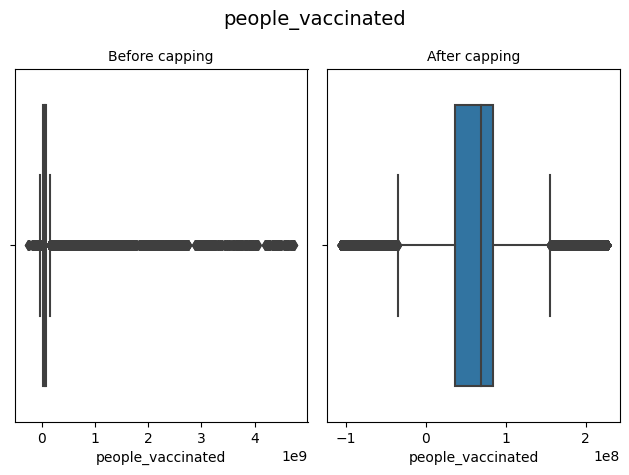

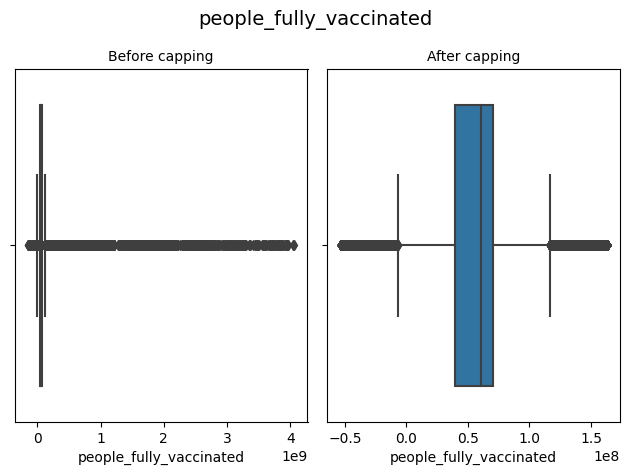

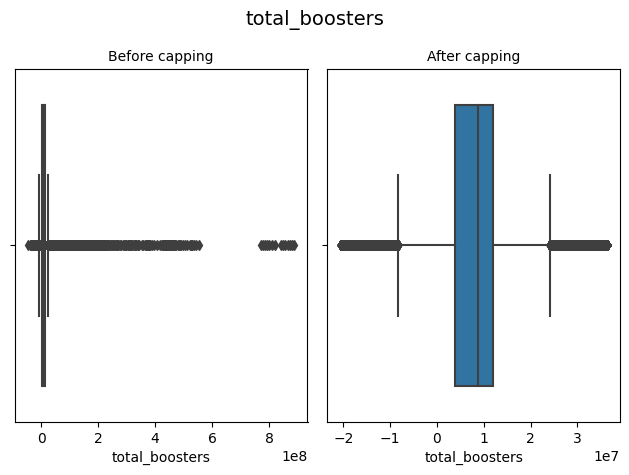

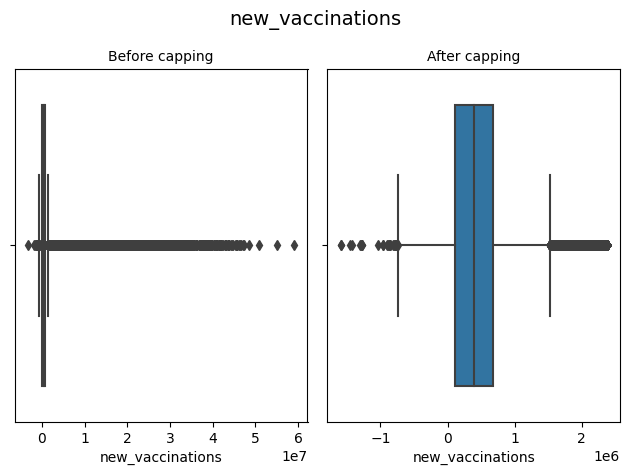

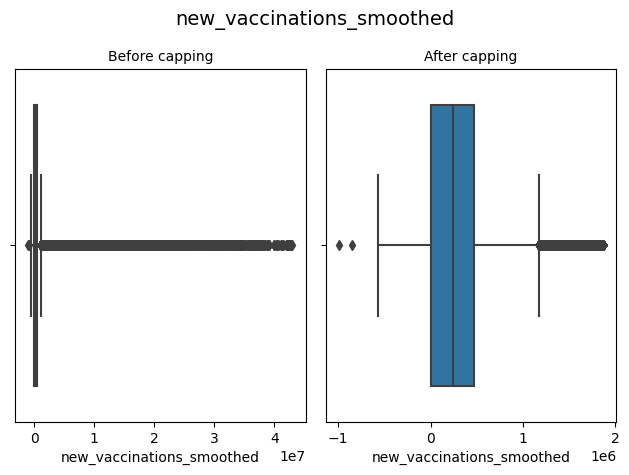

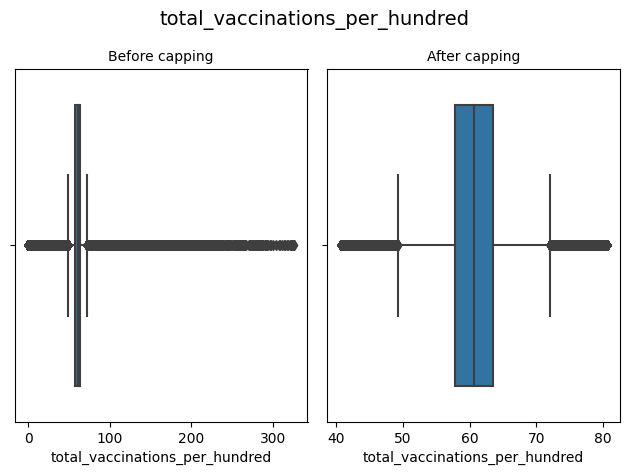

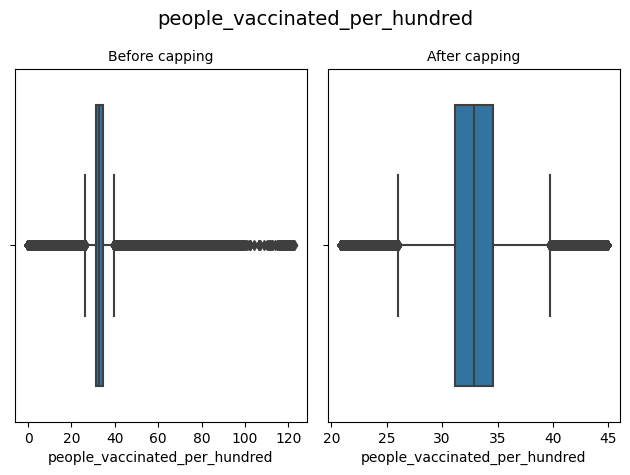

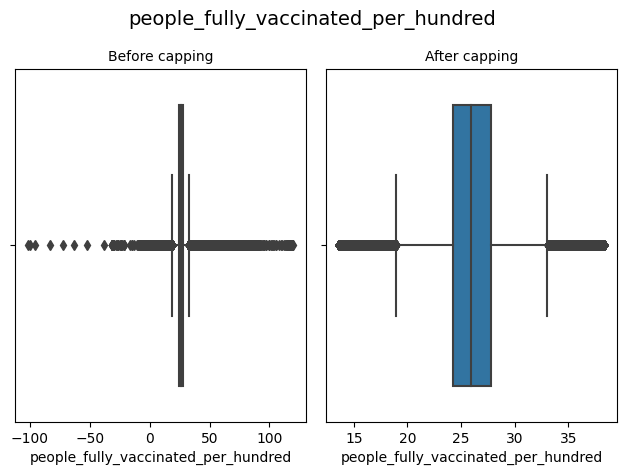

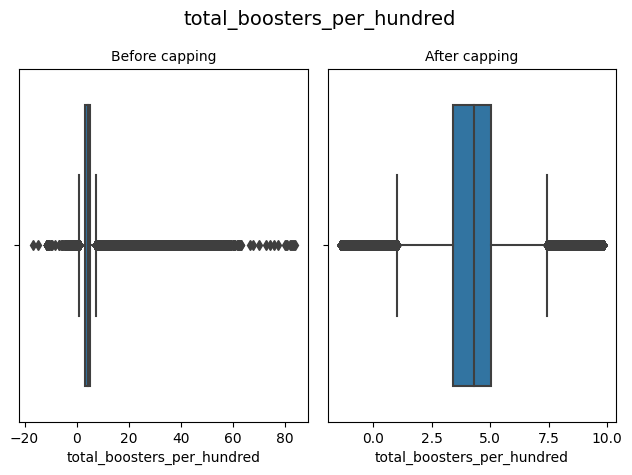

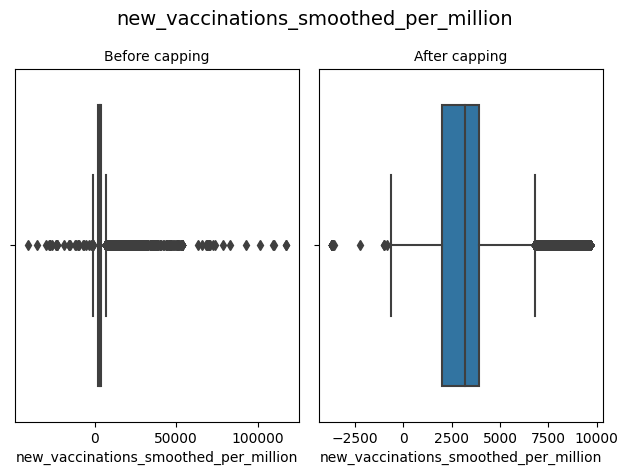

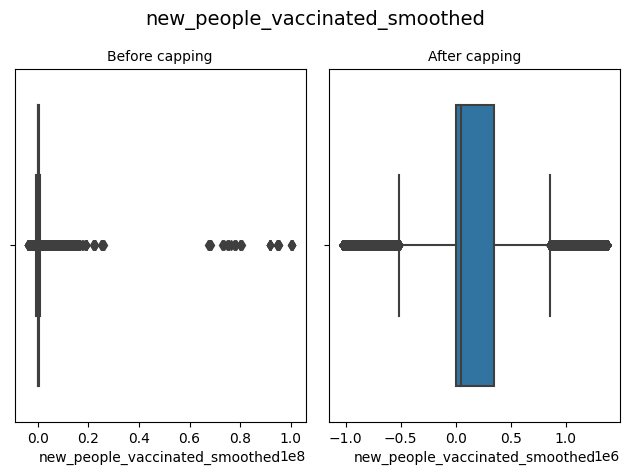

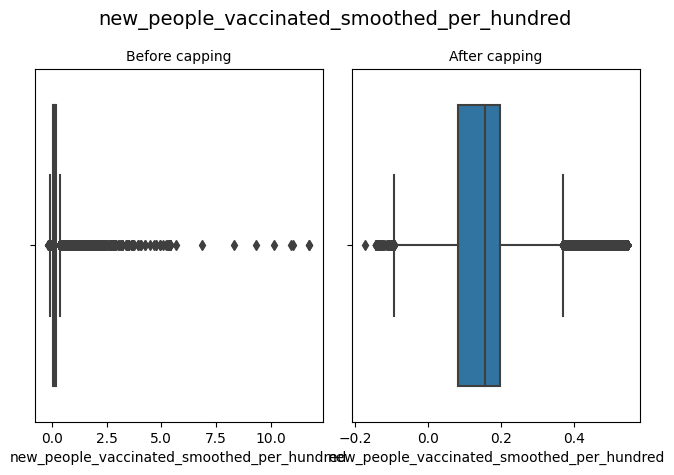

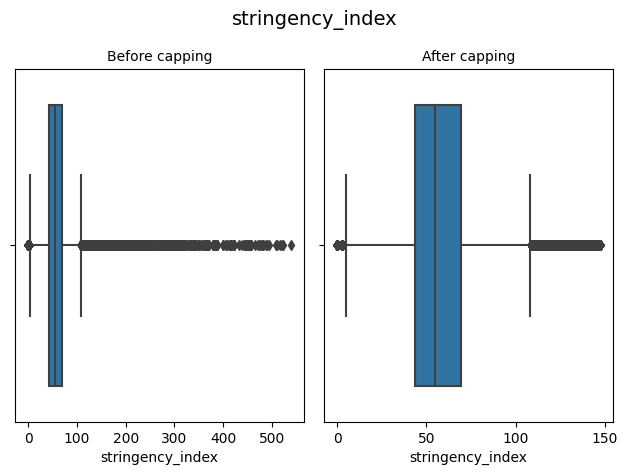

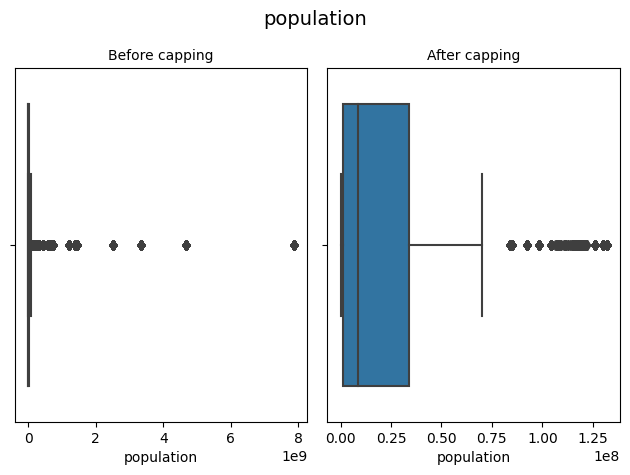

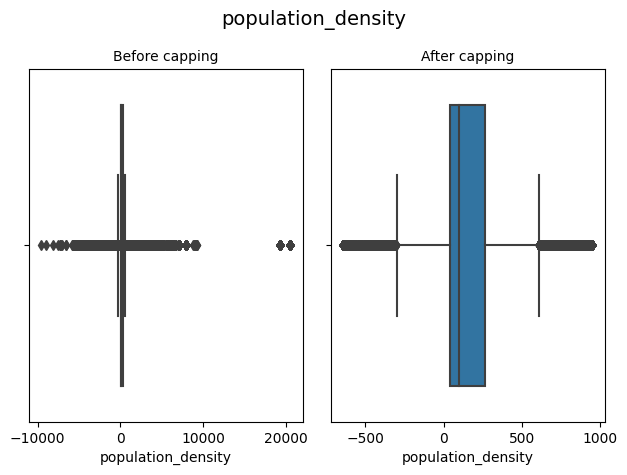

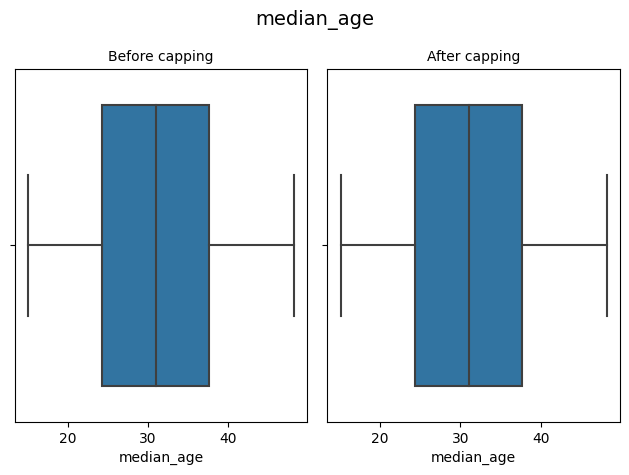

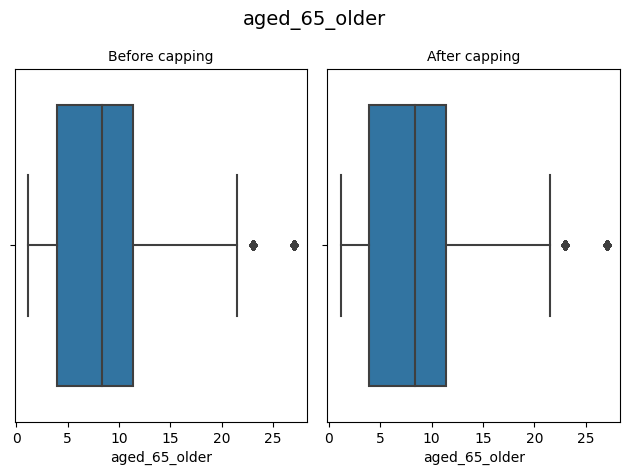

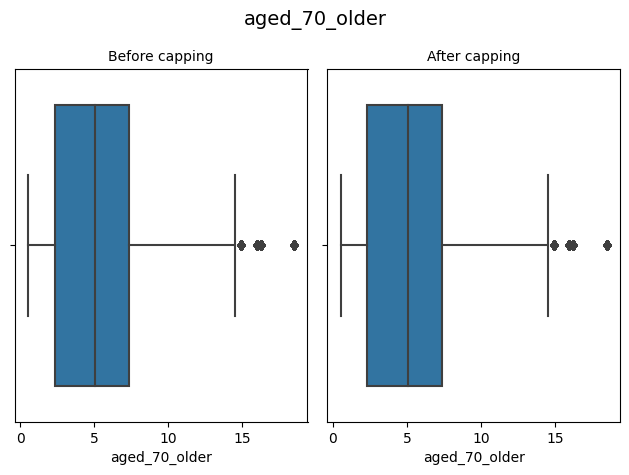

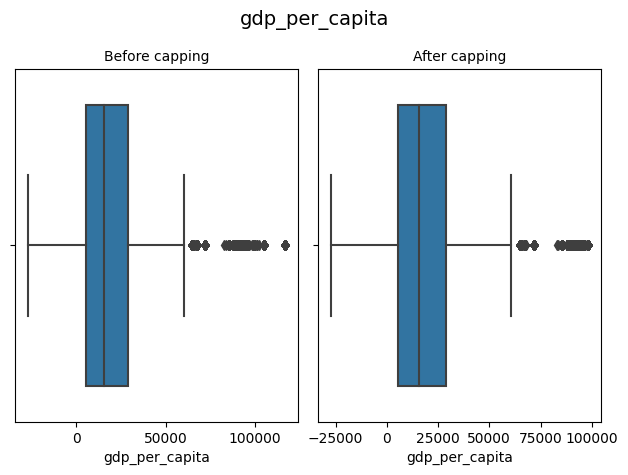

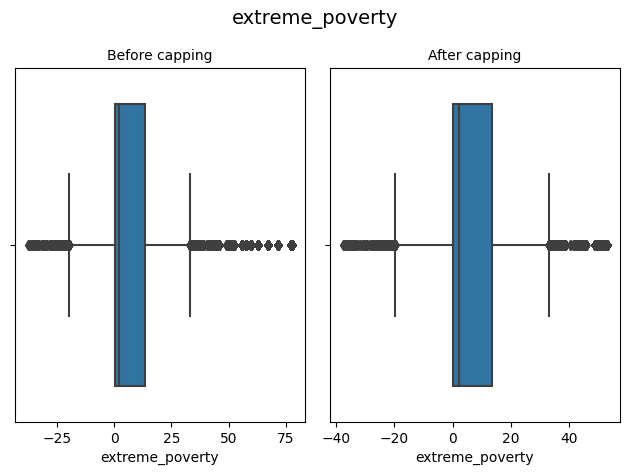

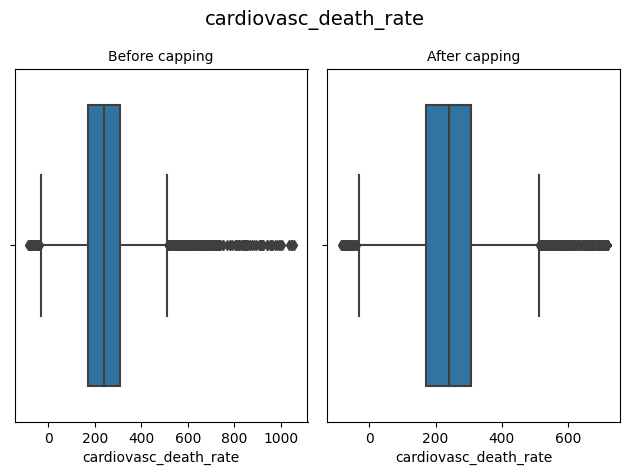

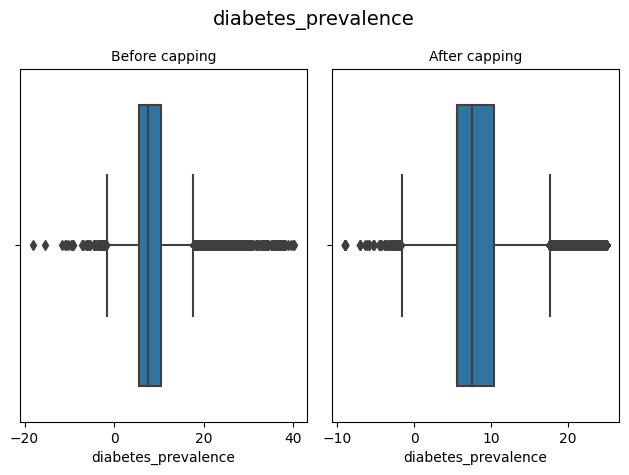

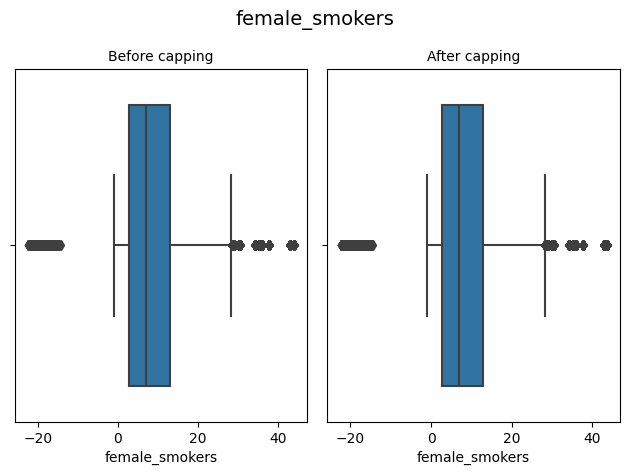

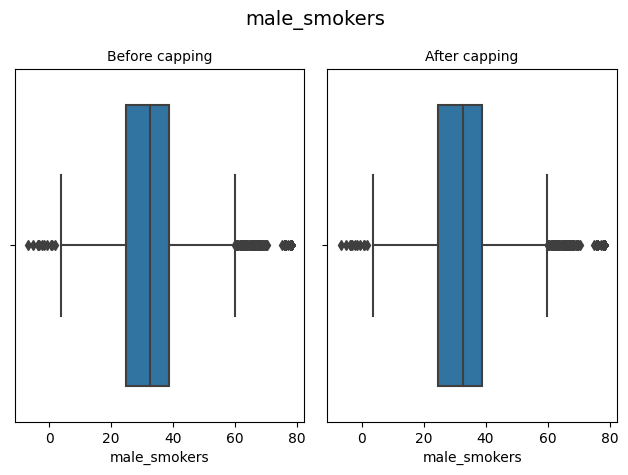

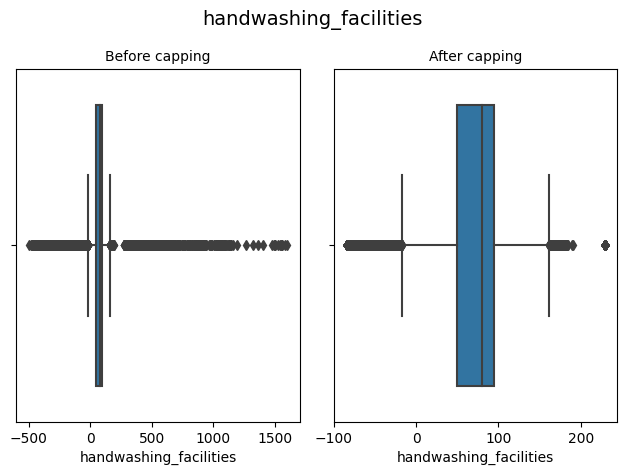

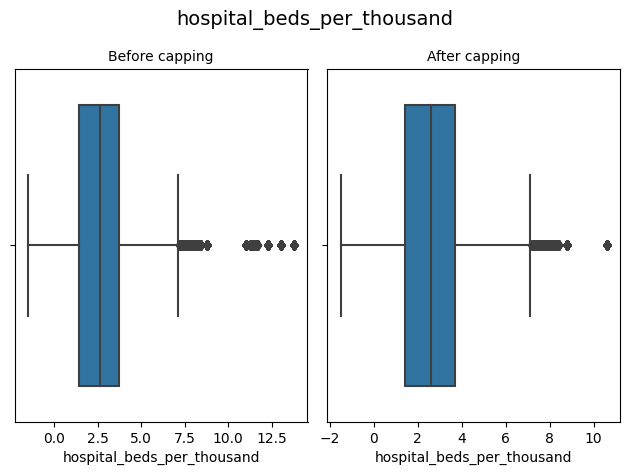

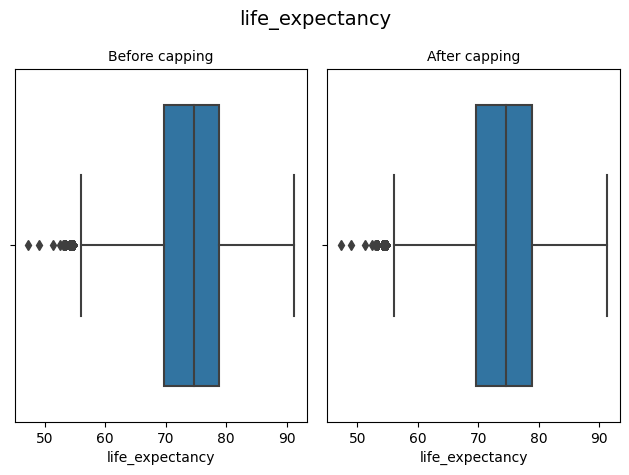

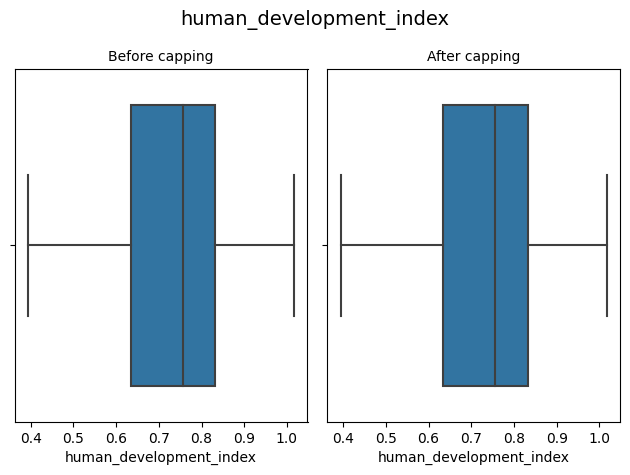

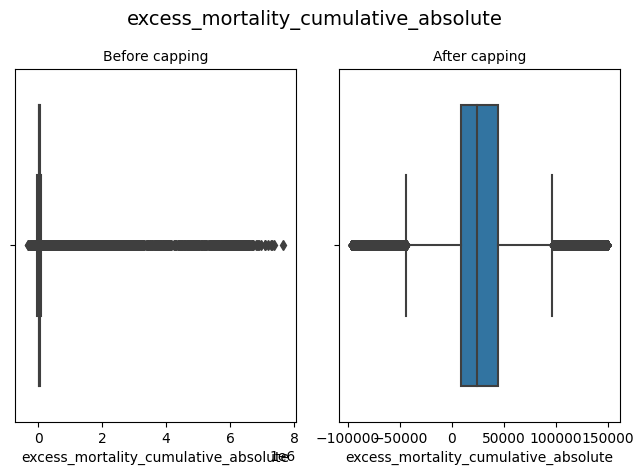

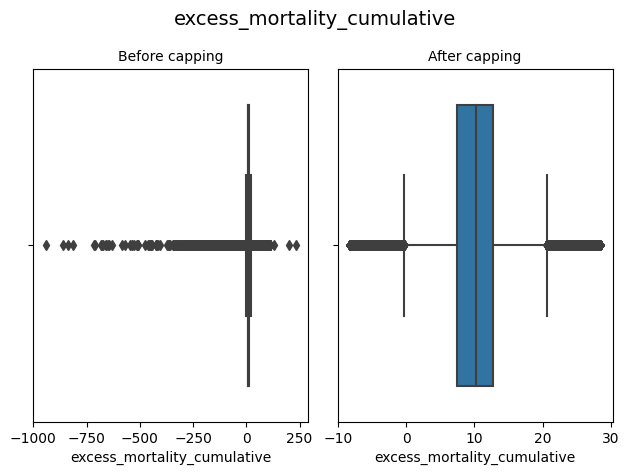

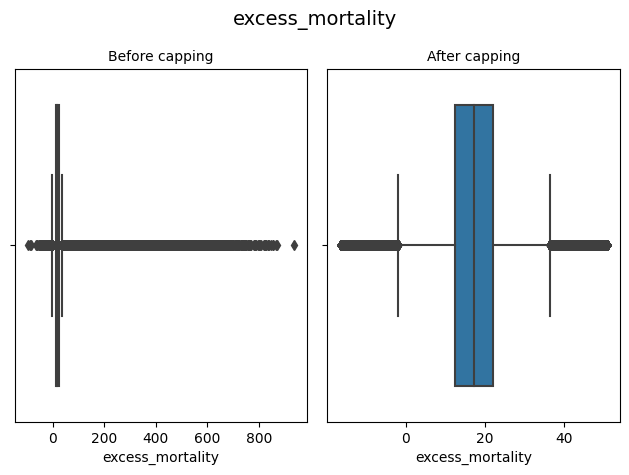

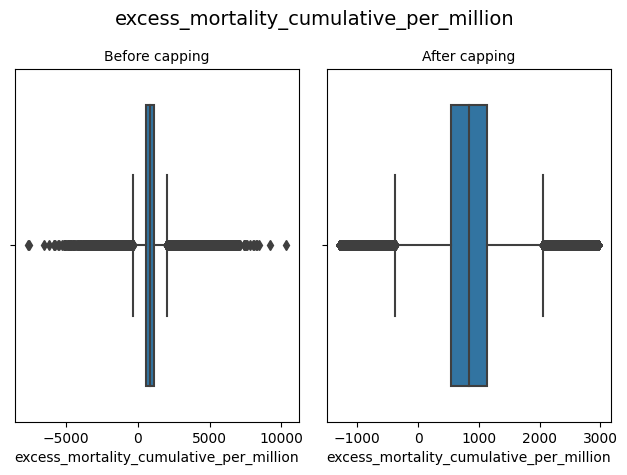

In [10]:
data_copy = data.copy()
# Capping extreme outliers using 3*IQR
winsorizer = feo.Winsorizer(capping_method='iqr', tail='both', fold=3, add_indicators=False)
data_copy[non_gaussian_columns] = winsorizer.fit_transform(data_copy[non_gaussian_columns])
for column in non_gaussian_columns:
    fig, ax = plt.subplots(nrows=1,ncols=2)
    plot1 = sns.boxplot(data=data, x=column,ax=ax[0])
    plot1.set_title('Before capping', fontsize=10)
    plot2 = sns.boxplot(data=data_copy, x=column,ax=ax[1])
    plot2.set_title('After capping', fontsize=10)
    fig.suptitle(column, fontsize=14)
    fig.tight_layout()
    plt.show()

## Removing outliers (OutlierTrimmer)

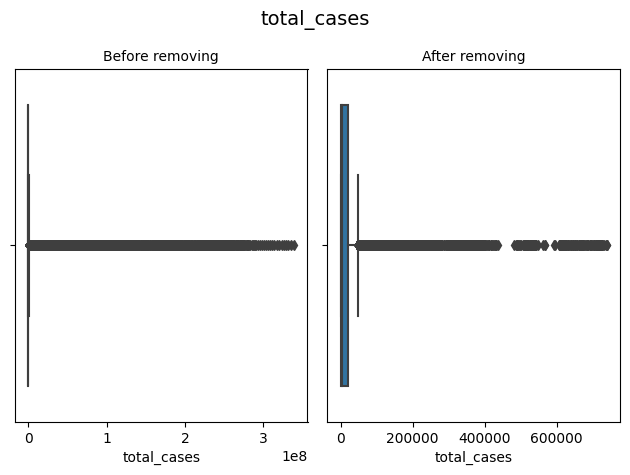

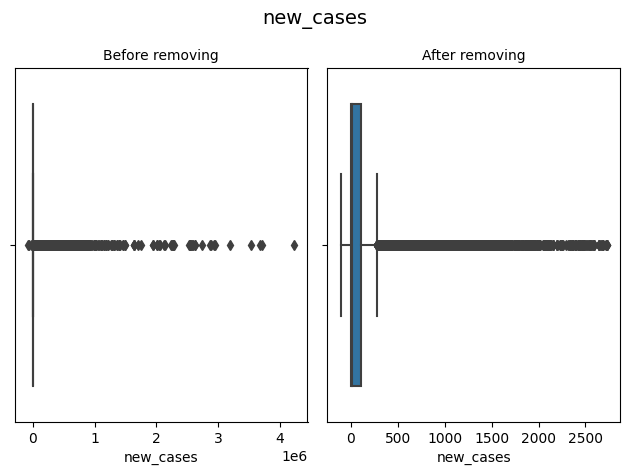

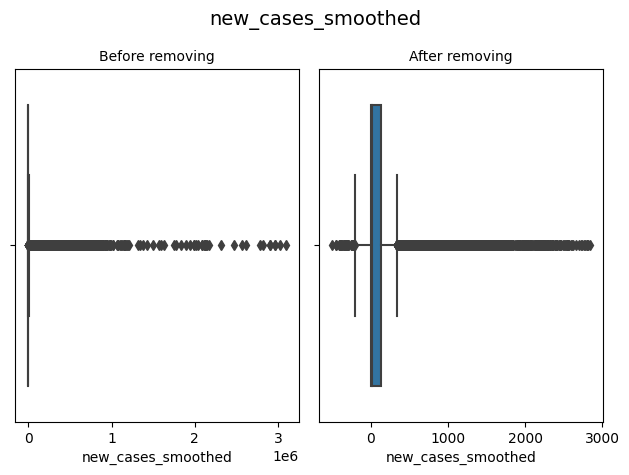

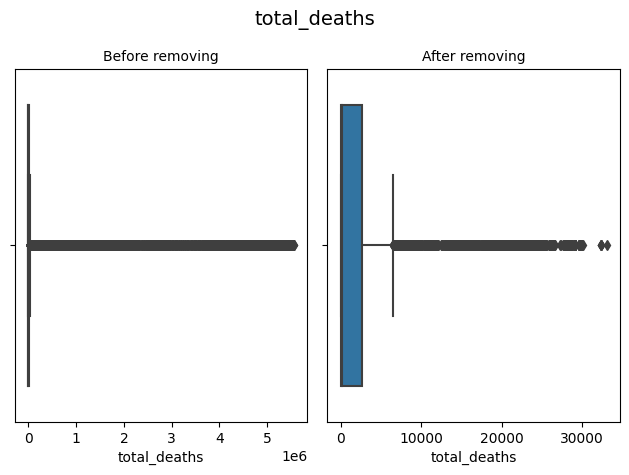

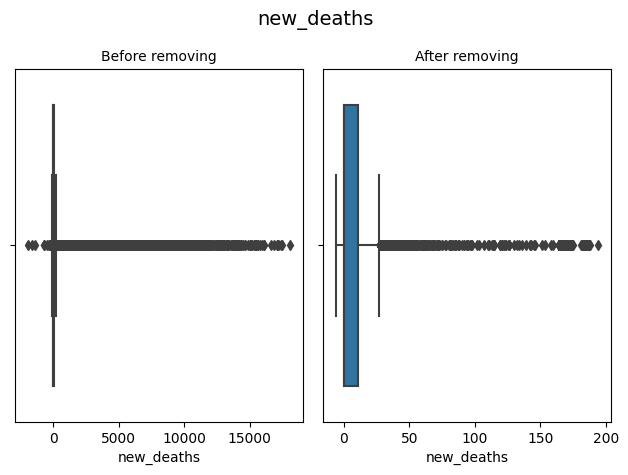

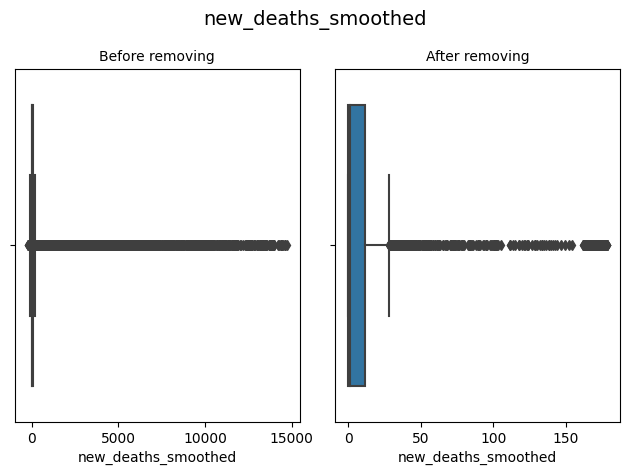

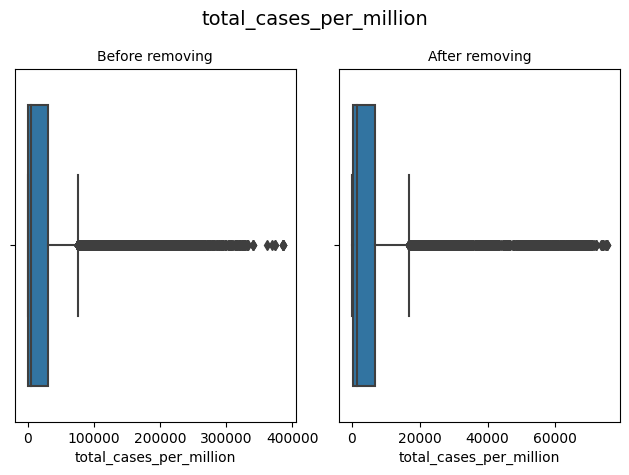

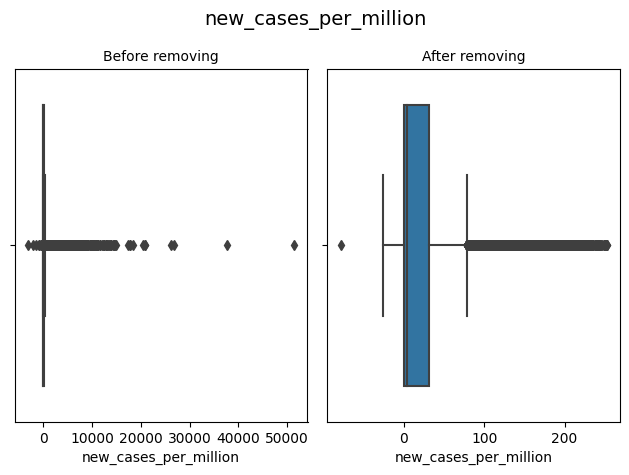

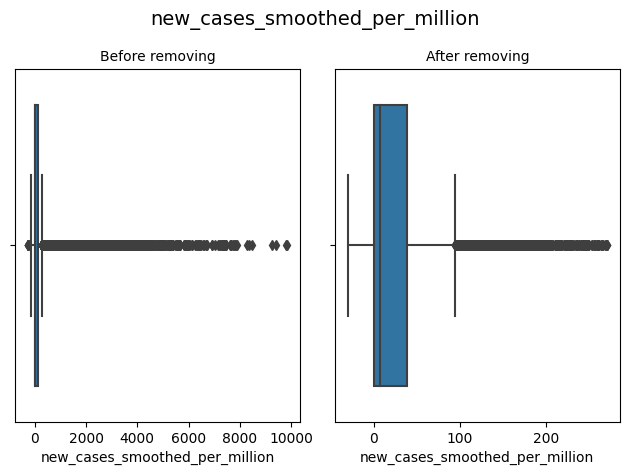

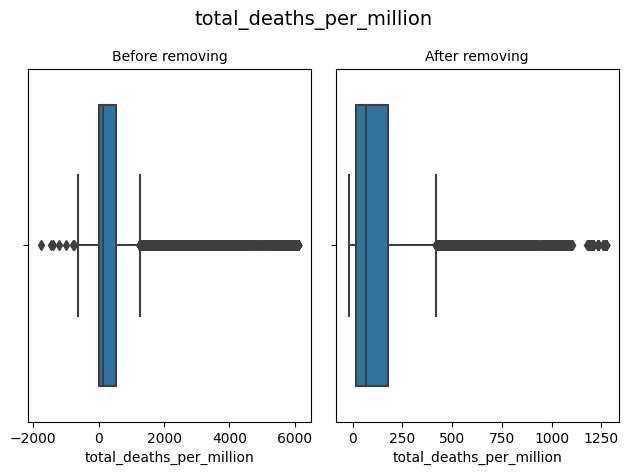

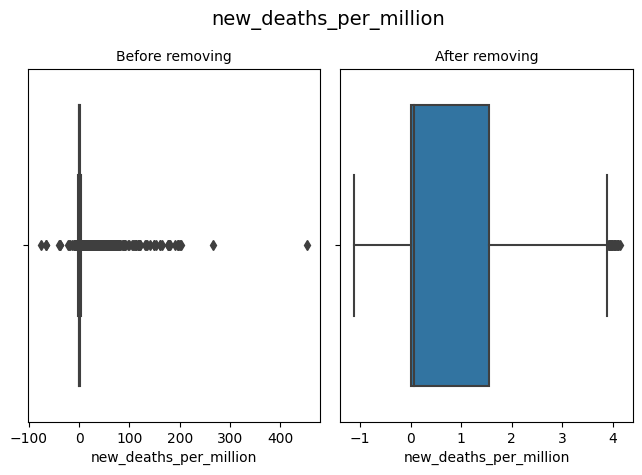

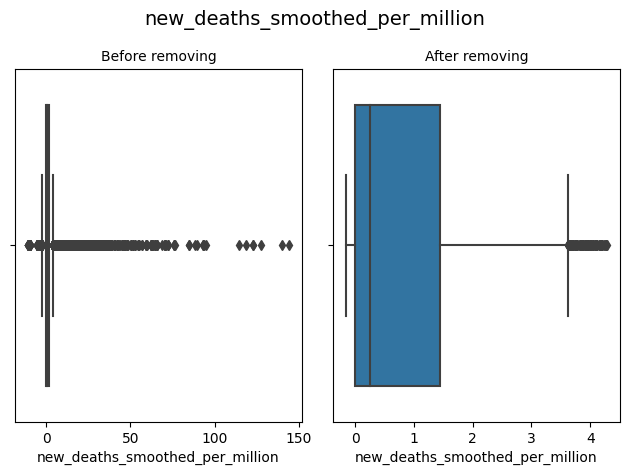

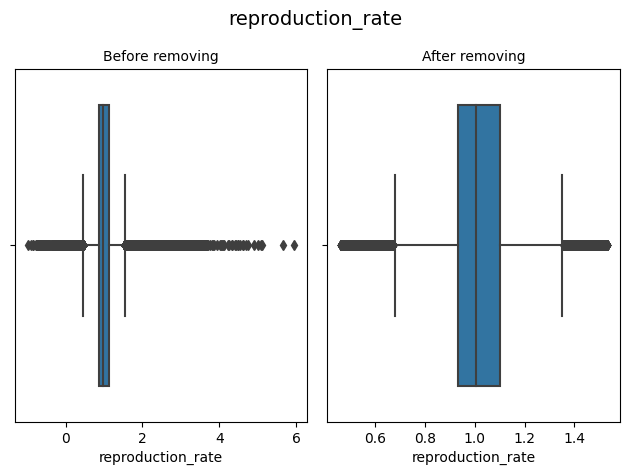

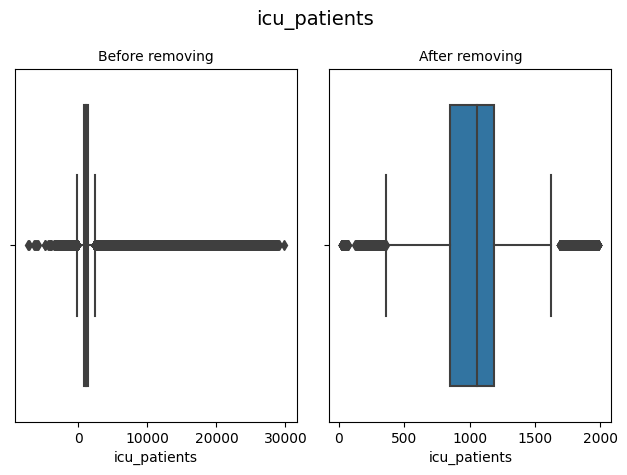

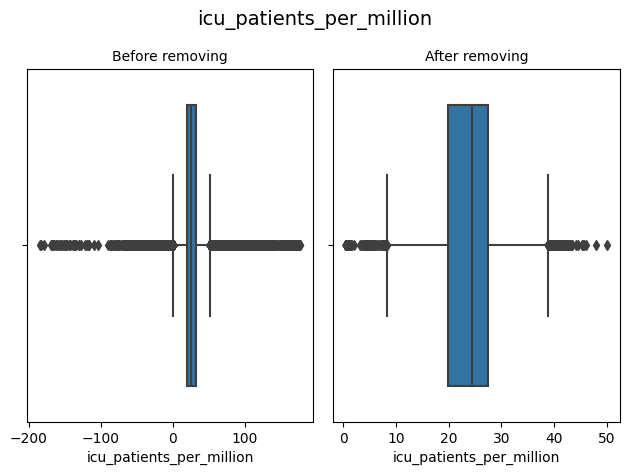

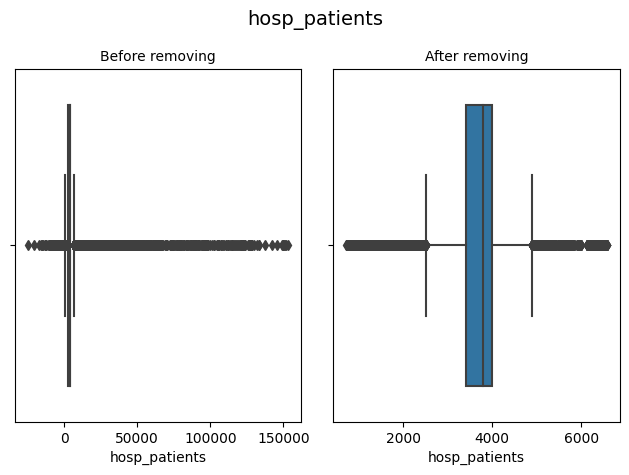

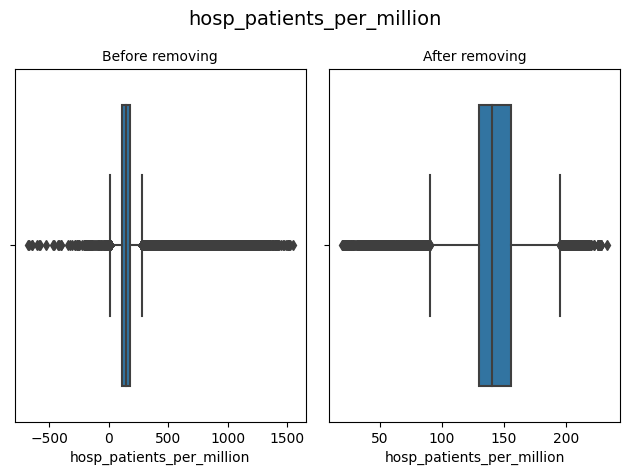

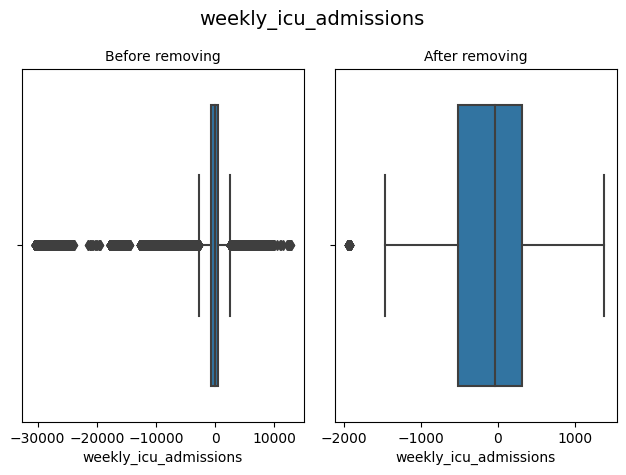

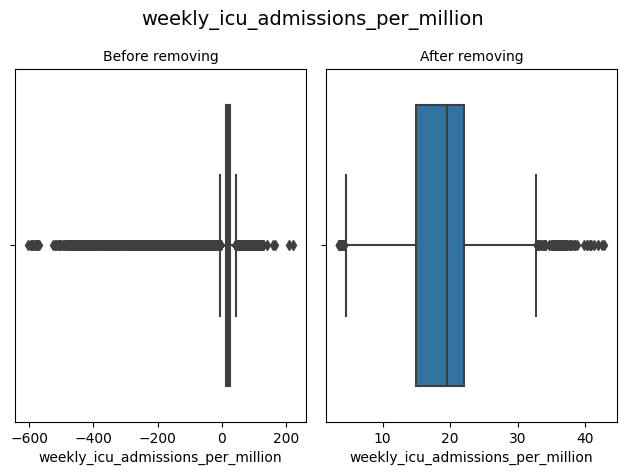

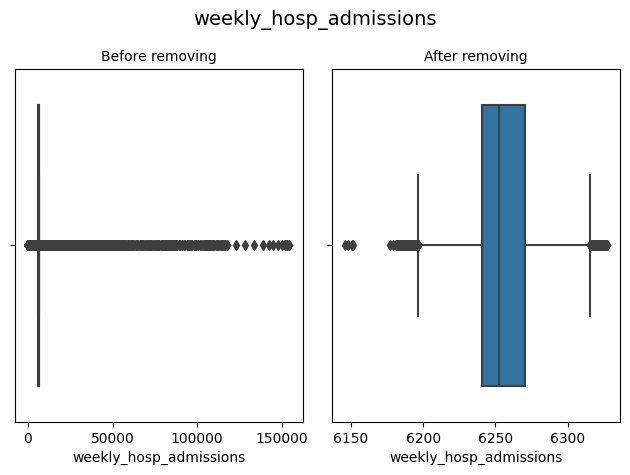

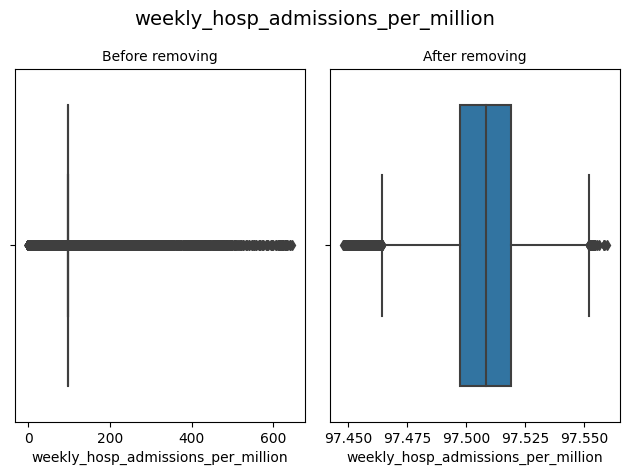

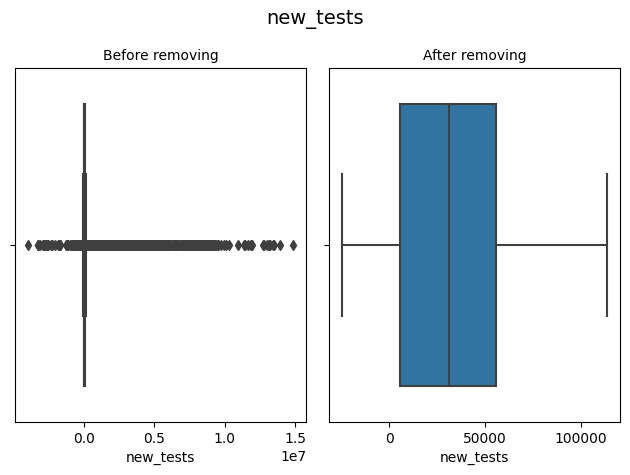

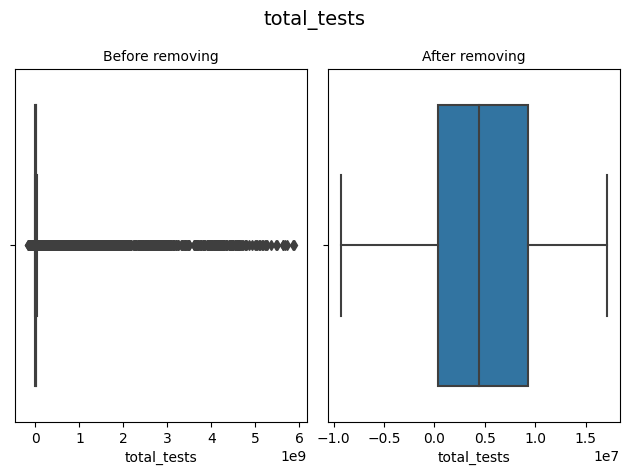

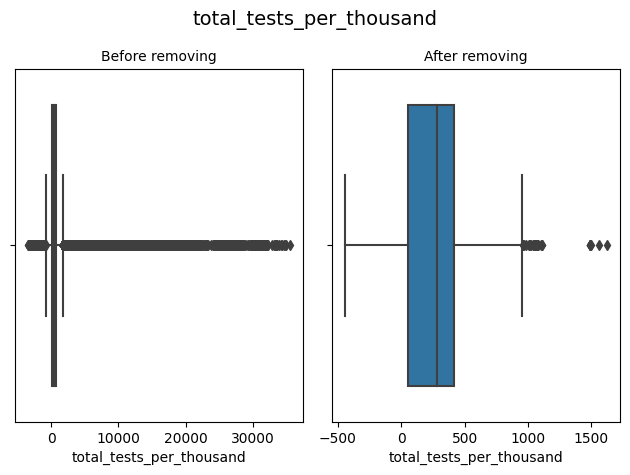

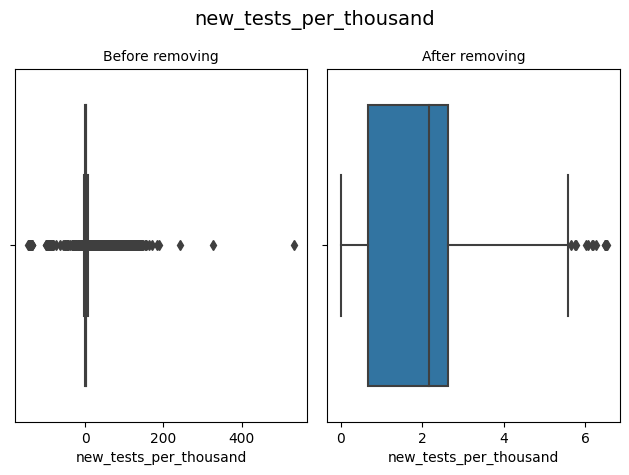

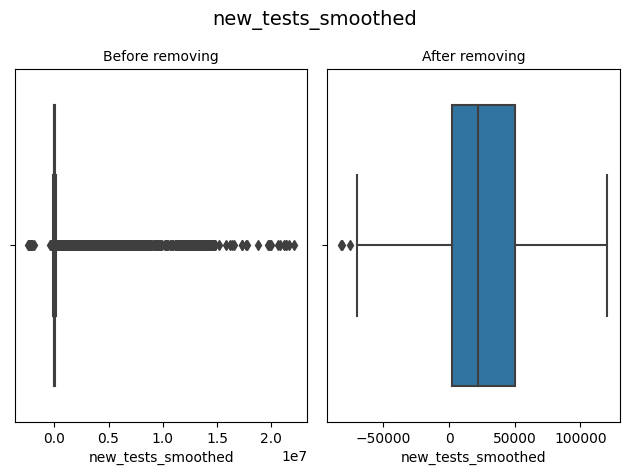

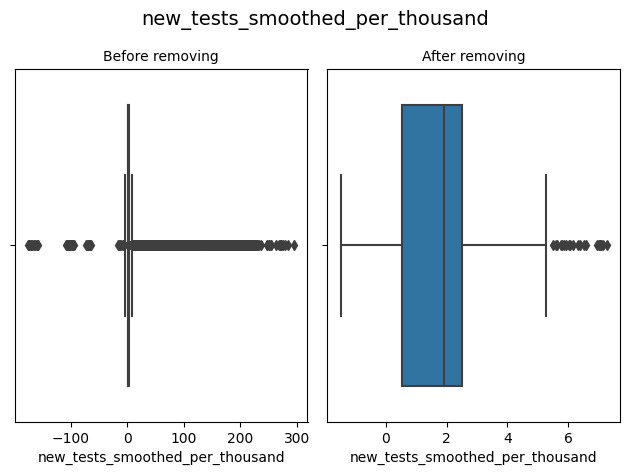

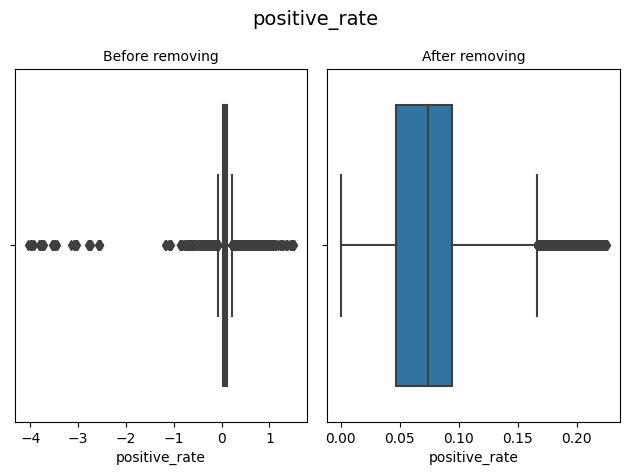

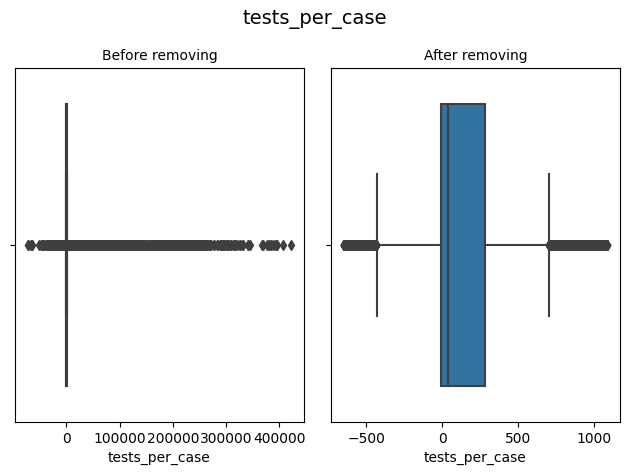

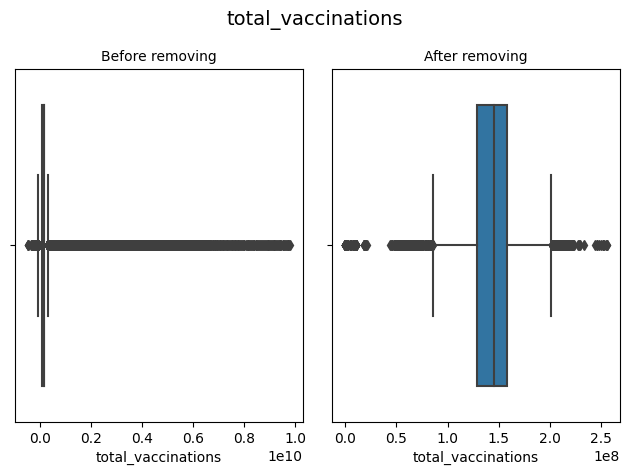

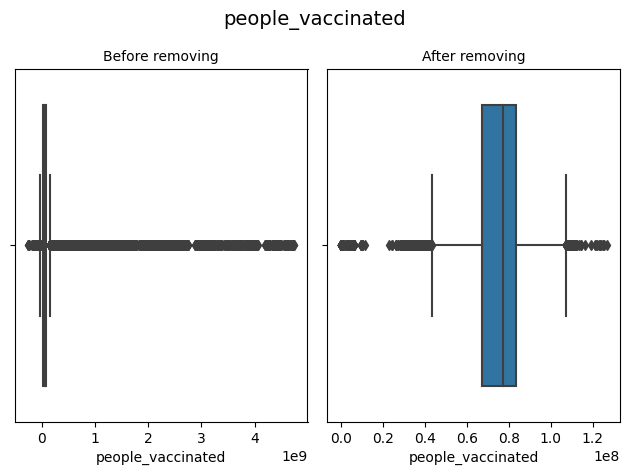

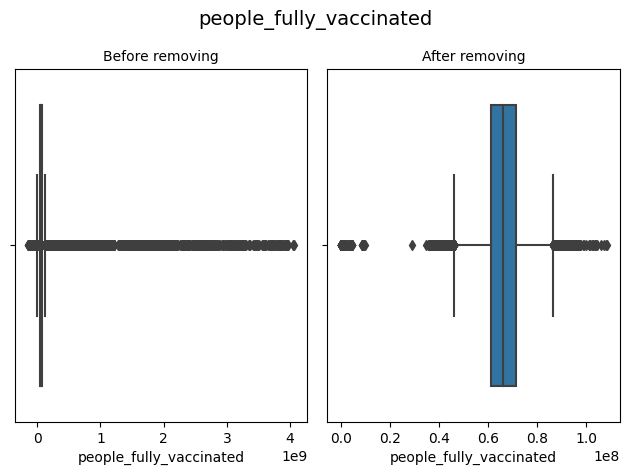

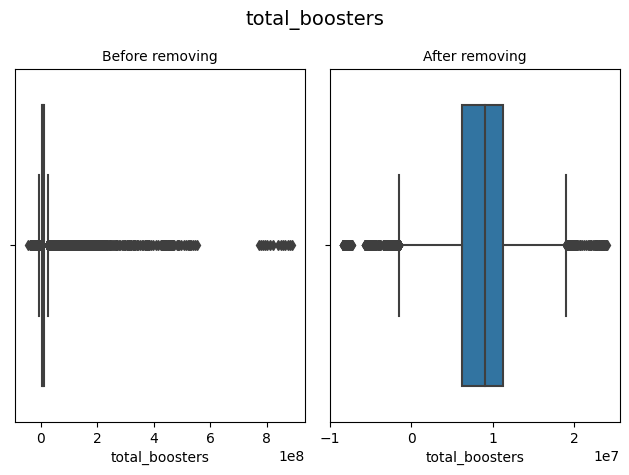

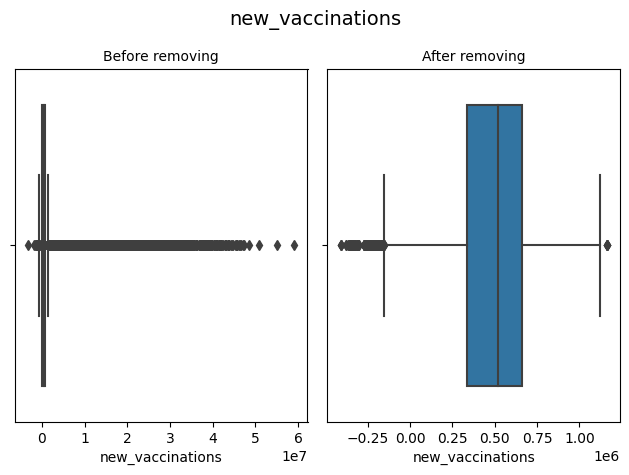

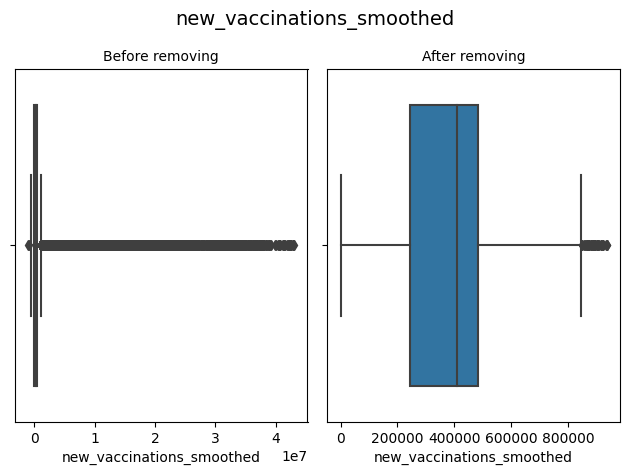

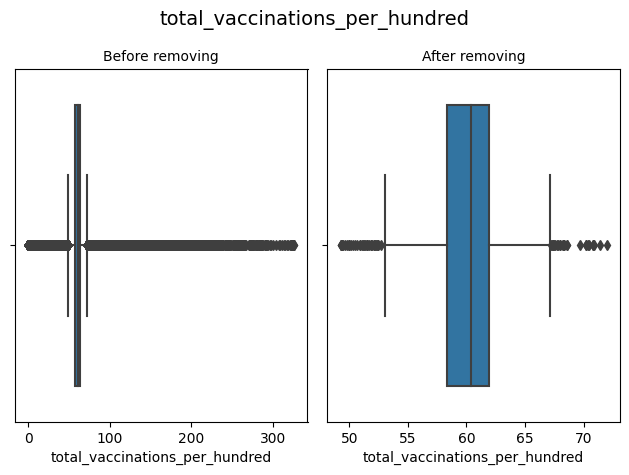

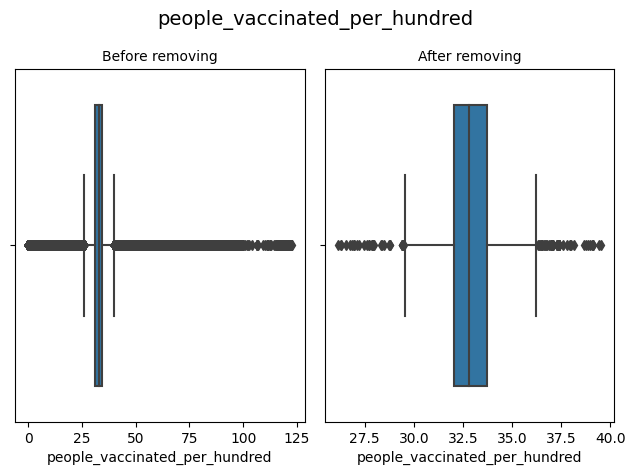

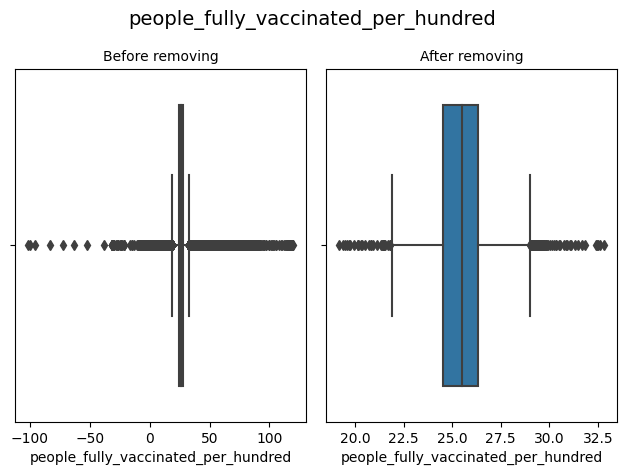

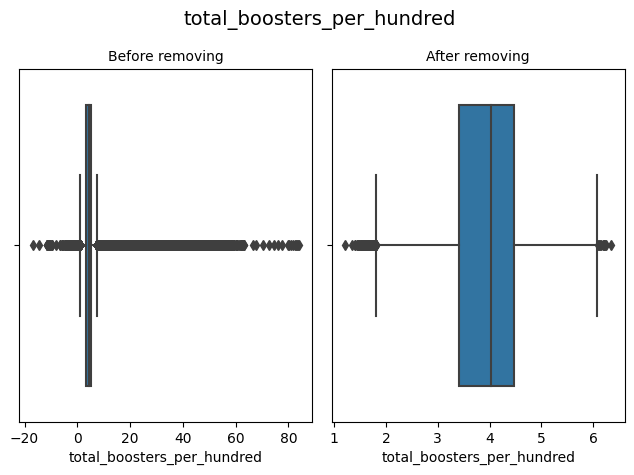

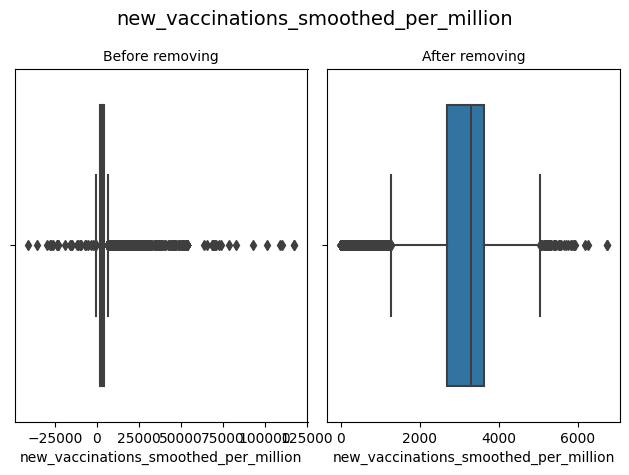

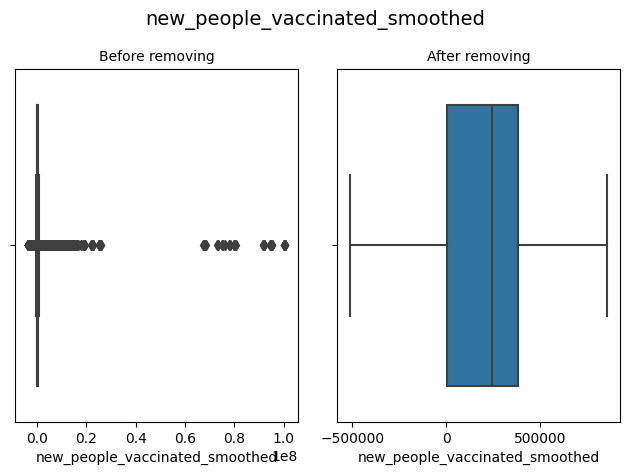

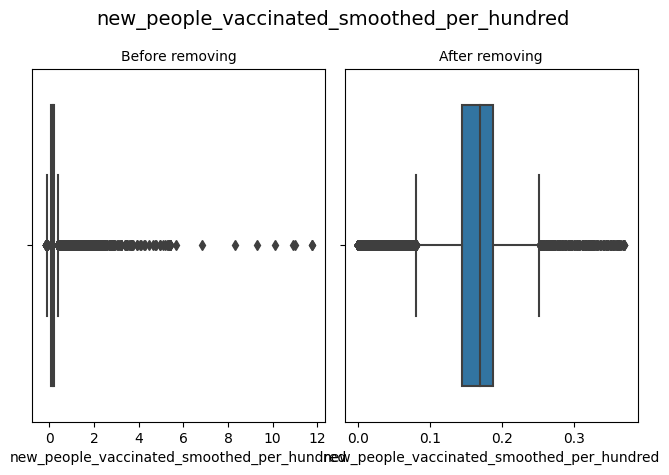

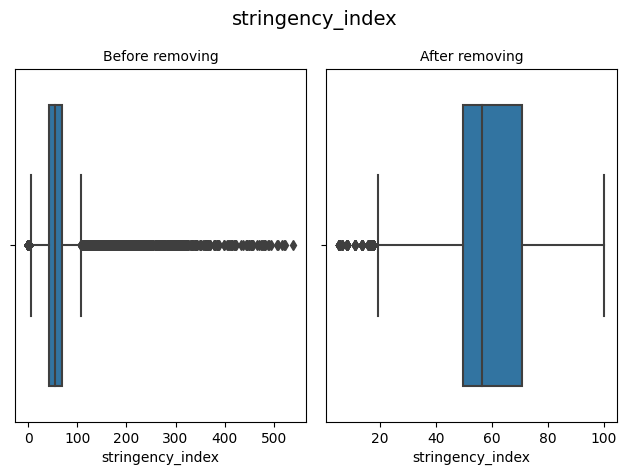

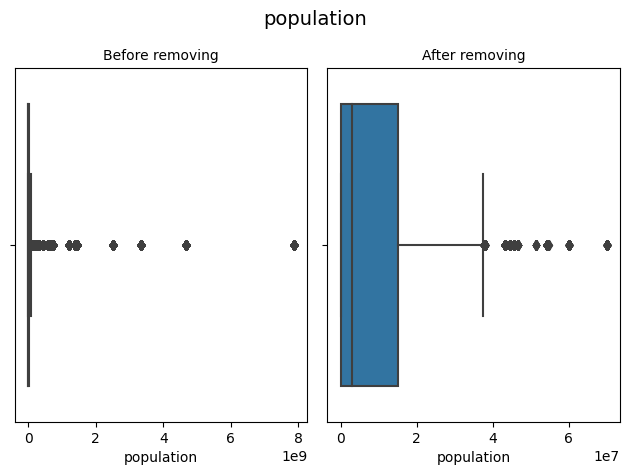

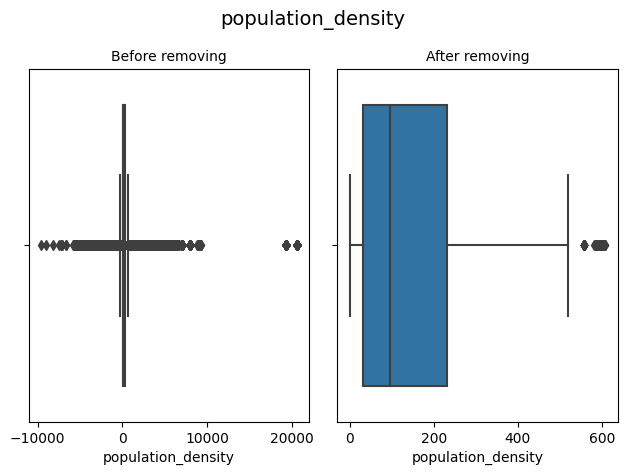

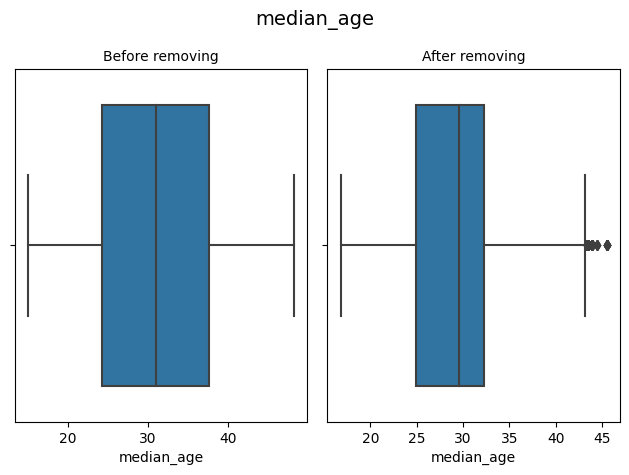

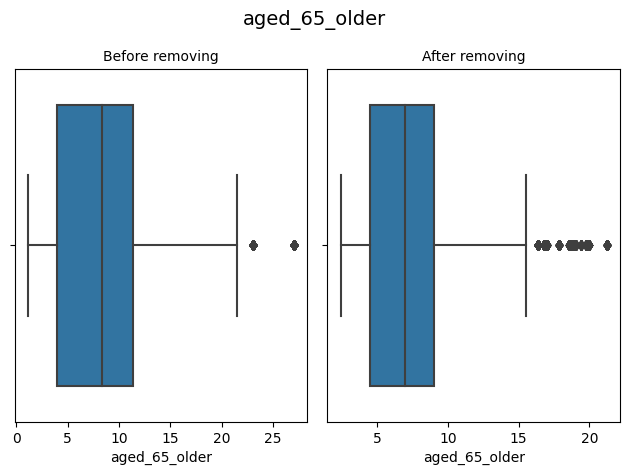

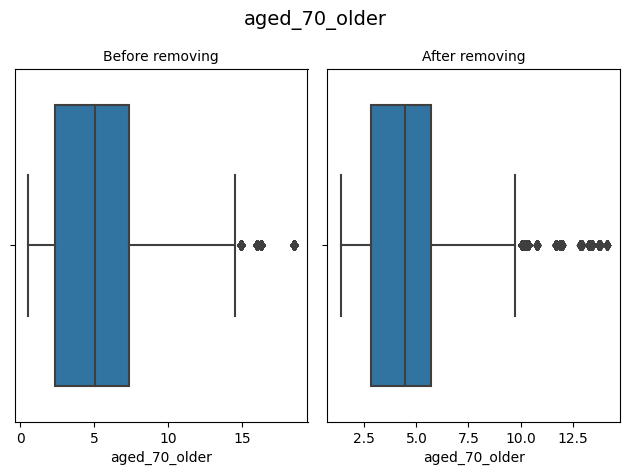

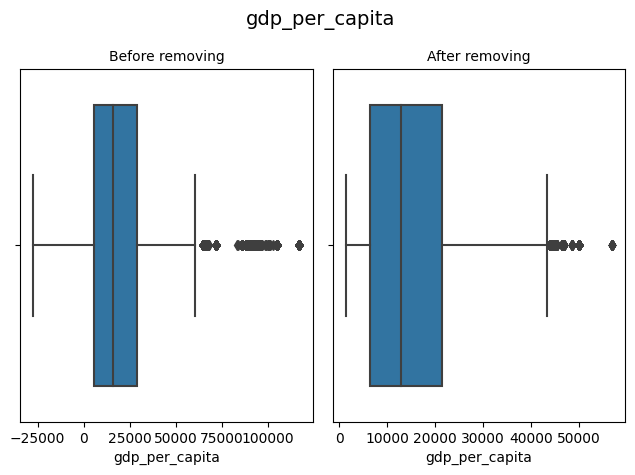

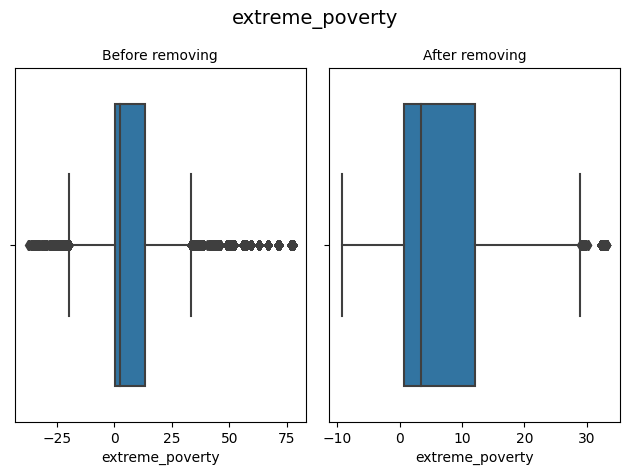

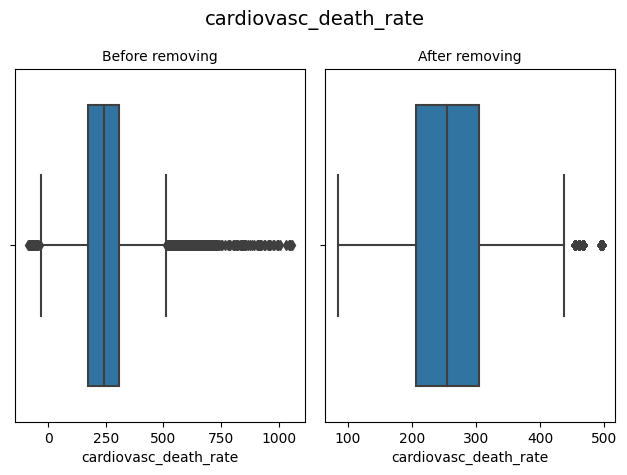

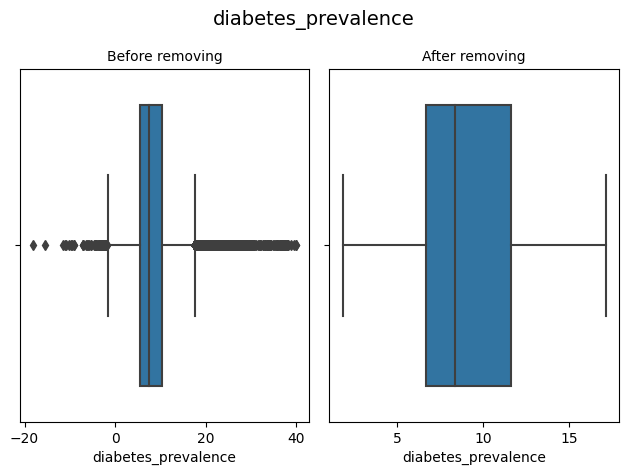

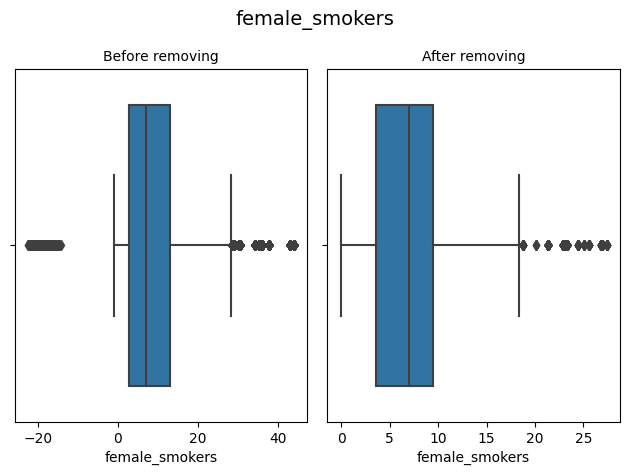

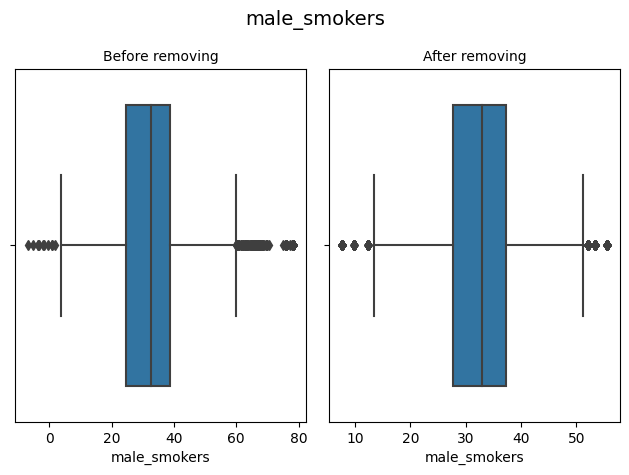

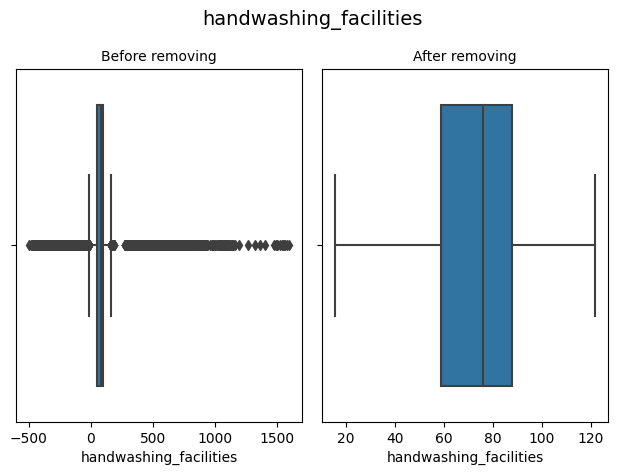

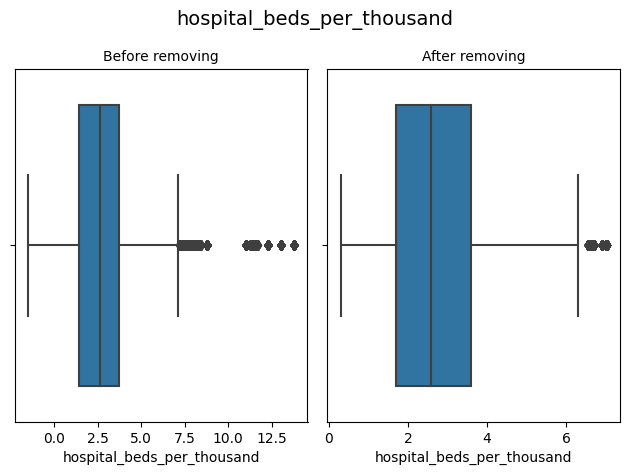

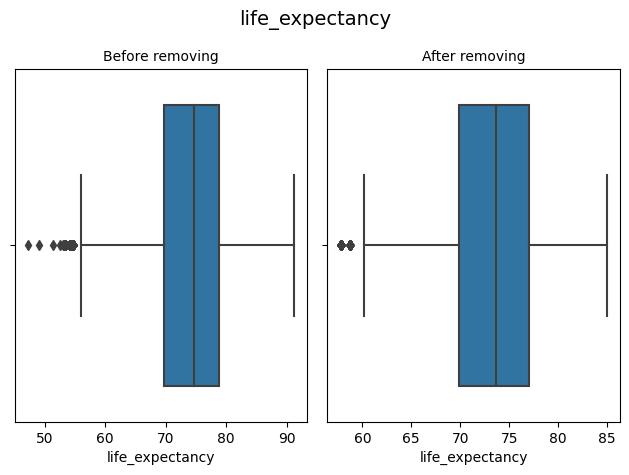

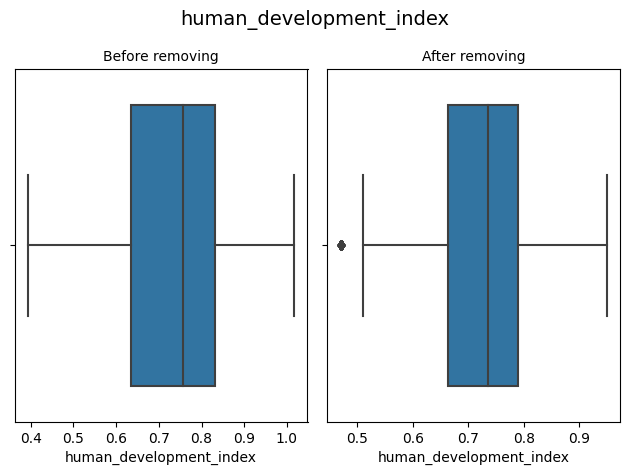

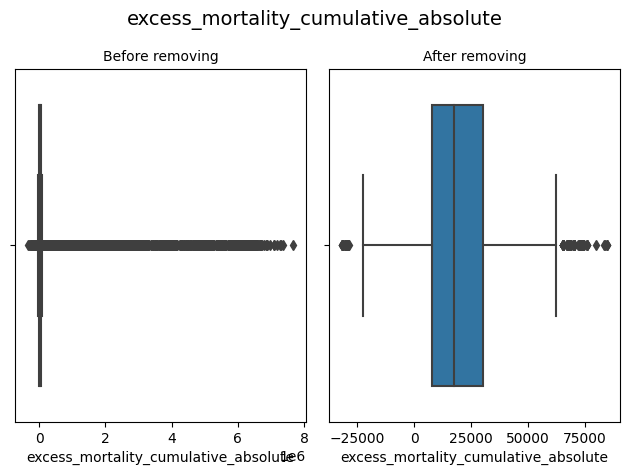

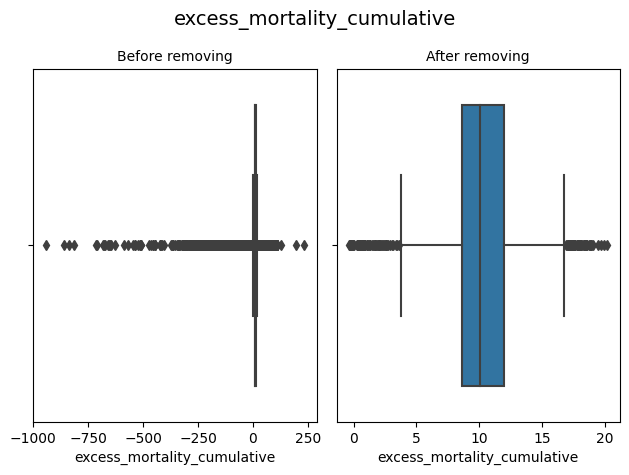

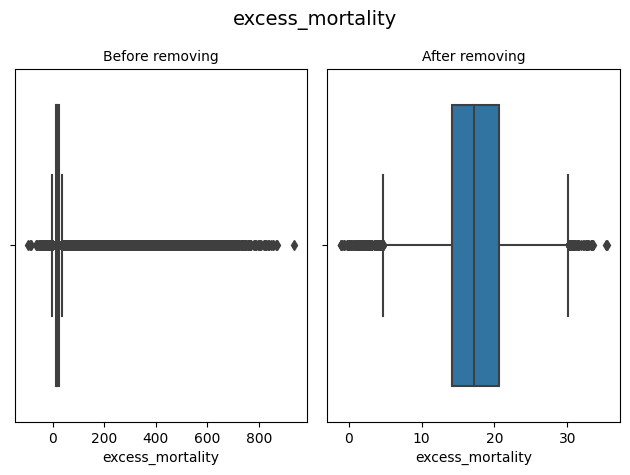

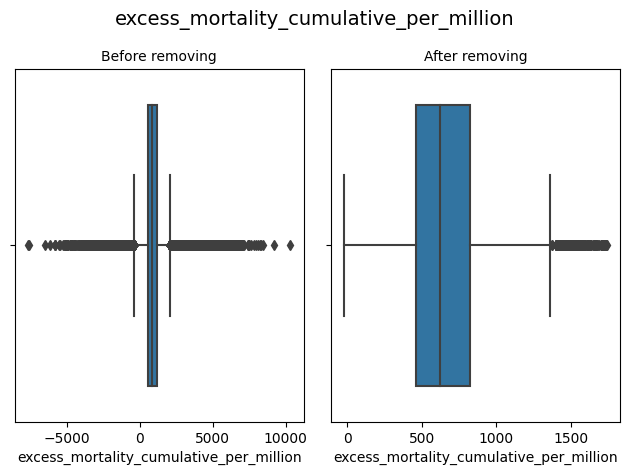

In [11]:
data_copy = data.copy()
# Removing outliers using 1.5*IQR
trimmer = feo.OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5)
data_copy[non_gaussian_columns] = trimmer.fit_transform(data_copy[non_gaussian_columns])
for column in non_gaussian_columns:
    fig, ax = plt.subplots(nrows=1,ncols=2)
    plot1 = sns.boxplot(data=data, x=column,ax=ax[0])
    plot1.set_title('Before removing', fontsize=10)
    plot2 = sns.boxplot(data=data_copy, x=column,ax=ax[1])
    plot2.set_title('After removing', fontsize=10)
    fig.suptitle(column, fontsize=14)
    fig.tight_layout()
    plt.show()

Note that after initial outlier removal, outliers can still exist due to changes in quantile values or original variable distribution is very heavily skewed.

## Machine Learning/Deep Learning Algorithms Sensitive to Outliers

Note that the following Machine Learning/Deep Learning models are sensitive to outliers:

1. Linear, Ridge, Lasso, ElasticNet regression
2. Logistic Regression
3. Support Vector Machine (SVM)
3. K Nearest Neighbors (KNN)
4. Clustering algorithms (KMeans, Hierarchical, DBScan, Affinity Propagation)
5. Neural Networks
6. Principal Component Analysis (PCA)

More details about why these algorithms are sensitive to outliers would be covered in Machine Learning section.